<a href="https://colab.research.google.com/github/ytg000629/ai4dl/blob/main/project/RNN%2CLSTM%2CGLOVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치,import, 데이터 준비



In [ ]:
!pip install keras_preprocessing
!pip install emoji
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.0-py2.py3-none-any.whl size=351211 sha256=4ef1f36c6bd516441f1481bf4ef22cbde8b94c23eb9dae085c6384b9a7030612
  Stored in directory: /root/.cache/pip/wheels/2a/0c/2c/07b5af72b120503fe24590691d24c462a25e5e530db8700a96
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha25

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import emoji

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import  Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import wordcloud
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences #keras_preprocessing

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, SimpleRNN, Bidirectional
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import os 
import warnings
warnings.filterwarnings(action  = 'ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from autocorrect import Speller 

In [ ]:
#%config Completer.use_jedi = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
df_test = pd.read_csv('drive/MyDrive//nlp-getting-started/test.csv')
df_sample = pd.read_csv('drive/MyDrive//nlp-getting-started/sample_submission.csv')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 데이터 전처리

In [ ]:
#불용어 사전 정의
stop=set(stopwords.words('english'))

#spell check 진행 정도 파악을 위
tqdm.pandas()

def text_preproccessing(df):  
    
    df = df.copy()
    
    # URL 제거
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # HTML tag 제거
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # 구두점 제거
    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # 이모티콘 제거
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    # 불용어 제거
    def remove_stopwords(x):
        return ' '.join([i for i in x.split() if i not in stop])


    # 스펠링 교정
    def spell_check(x):
        spell = Speller(lang='en')
        return " ".join([spell(i) for i in x.split()])


    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['text']=df['text'].apply(lambda x : remove_emoji(x))
    df['text']=df['text'].apply(lambda x : remove_stopwords(x))
    #df['text']=df['text'].progress_apply(lambda x : spell_check(x))


    return df

In [ ]:
df_train = text_preproccessing(df_train)
df_test = text_preproccessing(df_test)

#50분 정도 소요

In [ ]:
df_train.shape

(7613, 6)

In [ ]:
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,38
2,5,NaN,NaN,All residents asked shelter place notified off...,1,133
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,65
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1,88


In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 China Taiwan


In [ ]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 6)

# RNN 한번만 나오는 단어 제거




In [ ]:
tokenizer = Tokenizer()                                    #토큰나이저 정의
tokenizer.fit_on_texts(df['text'])                         #문자데이터 입력받아서 리스트로 변환
sequences = tokenizer.texts_to_sequences(df['text'])       #단어를 숫자로

print(sequences[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
word_to_index = tokenizer.word_index #단어와 숫자의 키-값 쌍을 포함하는 딕셔너리

In [ ]:
#word_to_index

In [ ]:
threshold = 2
total_cnt = len(word_to_index)    # 단어의 수
rare_cnt = 0                      # 등장 빈도수가 1인 것들 개수 카운트
total_freq = 0                    # 훈련 데이터 전체 단어 빈도수 총 합
rare_freq = 0                     # 등장 빈도수가 1인 것들의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 14308
단어 집합(vocabulary)에서 희귀 단어의 비율: 62.77090462402387
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.831596506017615


In [ ]:
#tokenizer.word_counts.items()       #등장 빈도가 1번인 애들 살펴보기

In [ ]:
total_cnt - rare_cnt + 1

8487

In [ ]:
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)    #한번만 나오는 단어 제거, 단어 빈도가 많은 순서로 5767개 단어 보존
tokenizer.fit_on_texts(df['text'])                                
sequences = tokenizer.texts_to_sequences(df['text'])     

print(sequences[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 1354], [123, 1522, 1434, 2187, 665, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 142]]


In [ ]:
a = []
for i in range(len(sequences)):
    a.append(len(sequences[i]))
max_len = max(a)
print(max_len)
#등장 빈도 1번인 애들 제거 후 가장 긴 tweet의 길이 : 26개의 단어

26


In [ ]:
train = pad_sequences(sequences, maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", train.shape)

훈련 데이터의 크기(shape): (10876, 26)


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8487


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train[:df_train.shape[0]], 
                                                                  df_train['target'].values,
                                                                  test_size=0.2,
                                                                  random_state=0,
                                                                  stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,            # callback 호출시 학습률을 1/2로 줄입니다
        patience=3,            # epoch 5 동안 개선되지 않으면 callback이 호출됩니다
)
]


history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           #그래프 보면서 에포크 늘려봤음 
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.5765
Epoch 1: val_accuracy improved from -inf to 0.58175, saving model to checkpoint_path.keras
96/96 [==============================] - 22s 164ms/step - loss: 0.6796 - accuracy: 0.5765 - val_loss: 0.6727 - val_accuracy: 0.5817 - lr: 1.0000e-04
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.6108
Epoch 2: val_accuracy improved from 0.58175 to 0.60801, saving model to checkpoint_path.keras
96/96 [==============================] - 8s 80ms/step - loss: 0.6570 - accuracy: 0.6108 - val_loss: 0.6574 - val_accuracy: 0.6080 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.6750
Epoch 3: val_accuracy improved from 0.60801 to 0.66054, saving model to checkpoint_path.keras
96/96 [==============================] - 6s 64ms/step - loss: 0.6279 - accuracy: 0.6750 - val_loss: 0.6318 - val_accuracy: 0.6605 - lr: 1.0000e

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

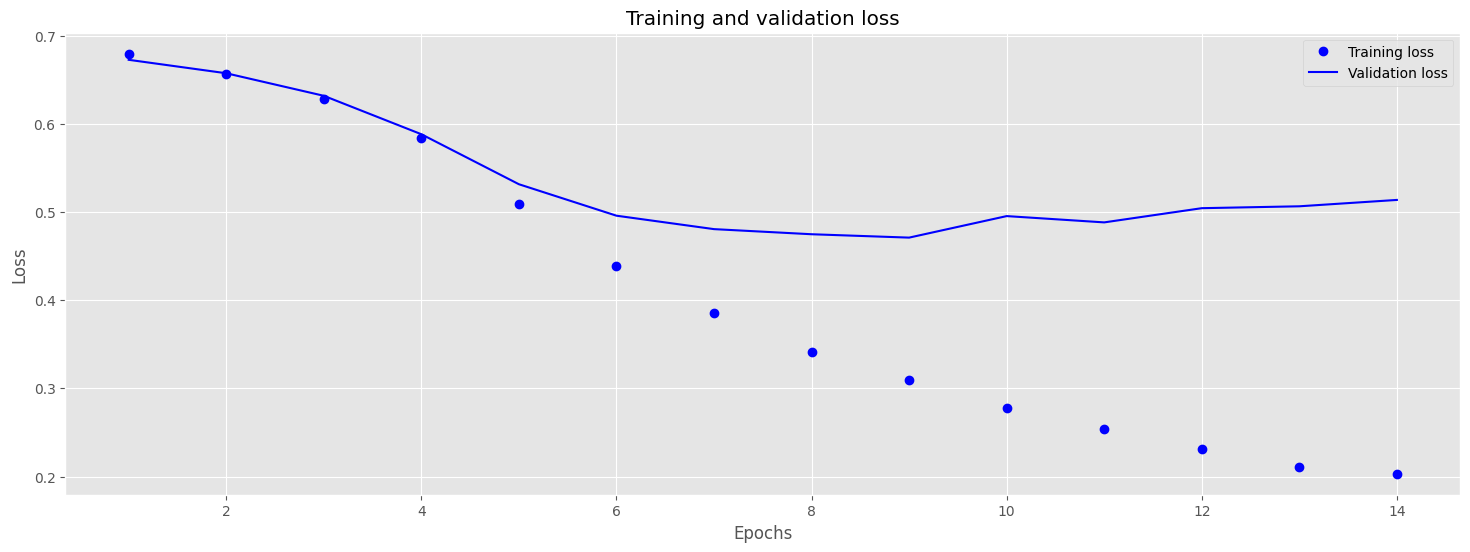

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

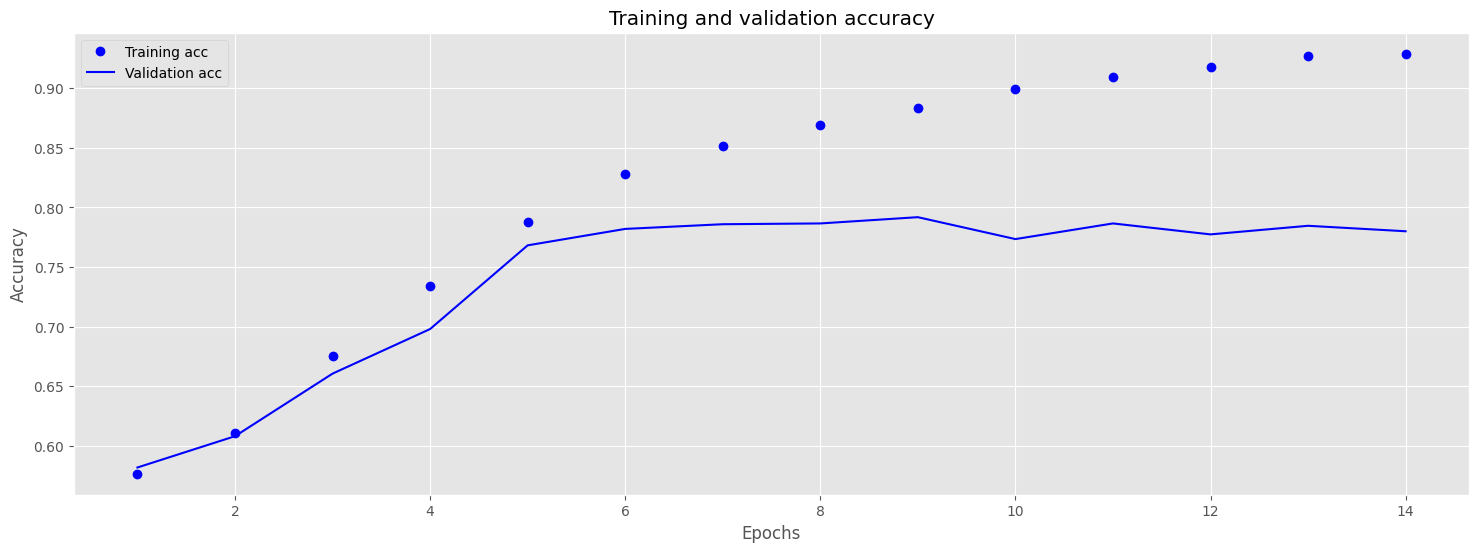

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(train[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 0.75605

102/102 [==============================] - 1s 4ms/step


#RNN 한번만 나오는 단어 제거 X

In [ ]:
tokenizer = Tokenizer()               #한번만 나오는 단어 제거X
tokenizer.fit_on_texts(df['text'])                           
sequences = tokenizer.texts_to_sequences(df['text'])     

print(sequences[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
a = []
for i in range(len(sequences)):
    a.append(len(sequences[i]))
max_len = max(a)
print(max_len)
#등장 빈도 1번인 애들 제거 후 가장 긴 tweet의 길이 : 28개의 단어

28


In [ ]:
train = pad_sequences(sequences, maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", train.shape)

훈련 데이터의 크기(shape): (10876, 28)


In [ ]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22795


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train[:df_train.shape[0]], 
                                                                  df_train['target'].values, 
                                                                  test_size=0.2, 
                                                                  random_state=0, 
                                                                  stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3,        
)
]


history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5568
Epoch 1: val_accuracy improved from -inf to 0.57190, saving model to checkpoint_path.keras
96/96 [==============================] - 28s 271ms/step - loss: 0.6842 - accuracy: 0.5568 - val_loss: 0.6789 - val_accuracy: 0.5719 - lr: 1.0000e-04
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.5885
Epoch 2: val_accuracy improved from 0.57190 to 0.59160, saving model to checkpoint_path.keras
96/96 [==============================] - 9s 97ms/step - loss: 0.6654 - accuracy: 0.5885 - val_loss: 0.6714 - val_accuracy: 0.5916 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.6481
Epoch 3: val_accuracy improved from 0.59160 to 0.63165, saving model to checkpoint_path.keras
96/96 [==============================] - 6s 67ms/step - loss: 0.6413 - accuracy: 0.6481 - val_loss: 0.6625 - val_accuracy: 0.6316 - lr: 1.0000e

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

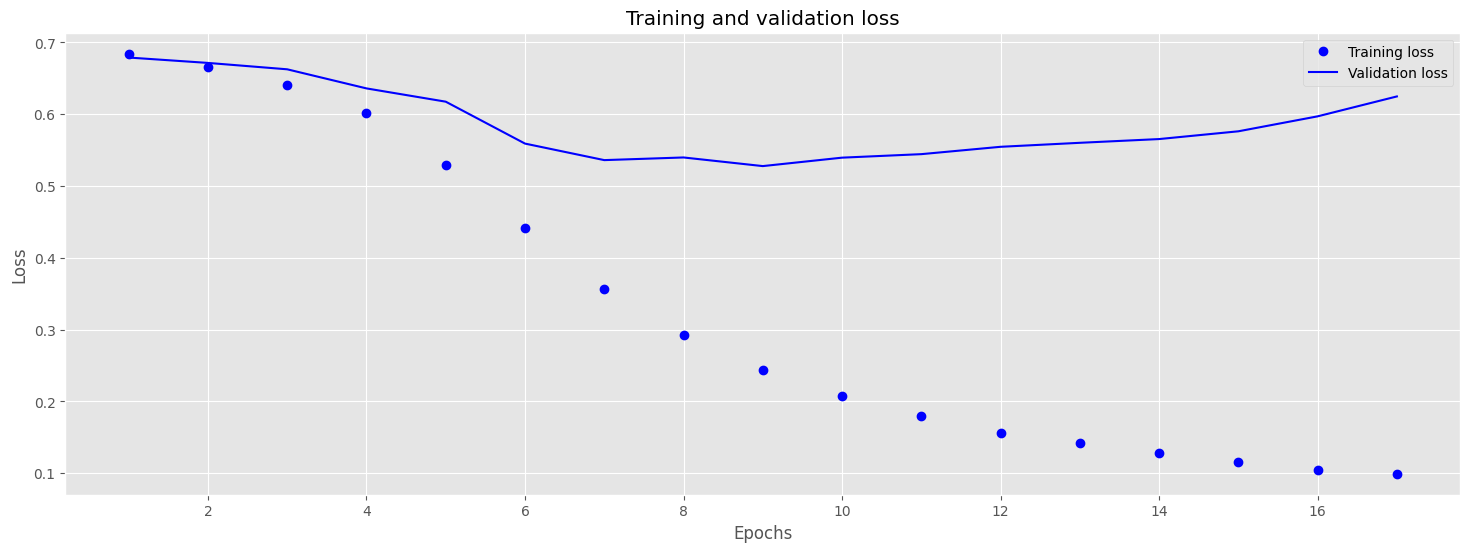

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

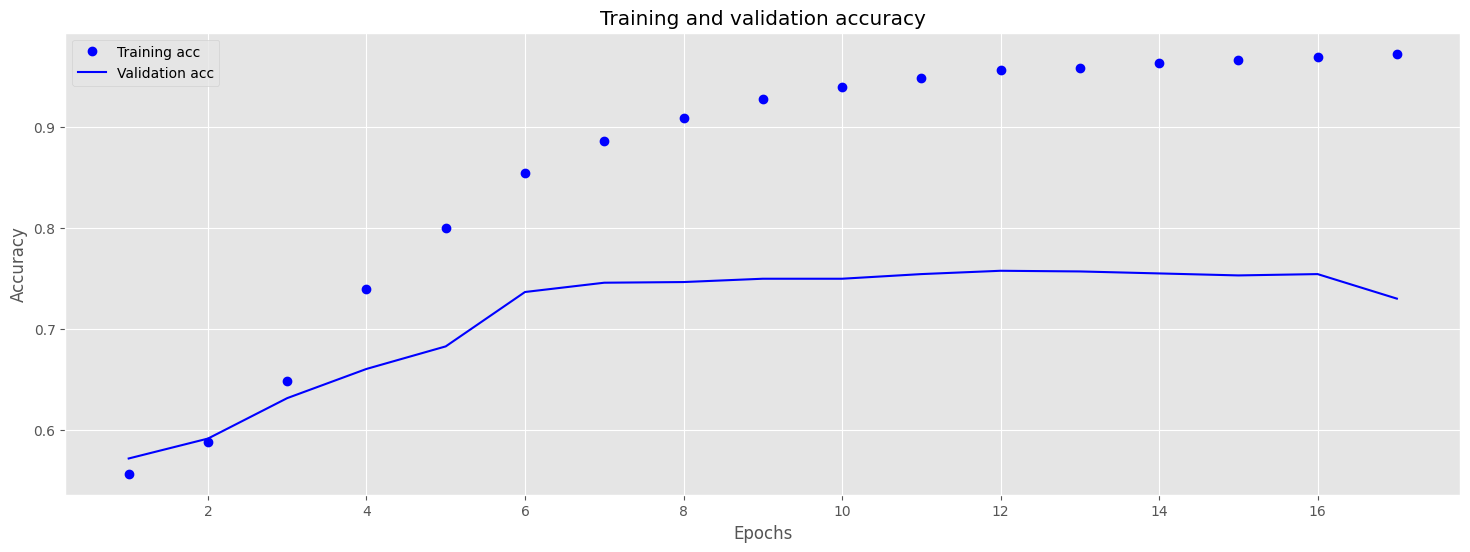

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(train[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 0.7395

102/102 [==============================] - 1s 4ms/step


# LSTM 한번만 나오는 단어 제거 X

In [ ]:
tokenizer = Tokenizer()                                        
tokenizer.fit_on_texts(df['text'])                                
sequences = tokenizer.texts_to_sequences(df['text'])     

print(sequences[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
a = []
for i in range(len(sequences )):
    a.append(len(sequences [i]))
max_len = max(a)
print(max_len)

#가장 긴 tweet의 길이 : 28개의 단어

28


In [ ]:
train = pad_sequences(sequences , maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", train.shape)

훈련 데이터의 크기(shape): (10876, 28)


In [ ]:
vocab_size = len(word_to_index)
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22794


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train[:df_train.shape[0]], 
                                                                  df_train['target'].values, 
                                                                  test_size=0.2, 
                                                                  random_state=0, 
                                                                  stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3,          
)
]


history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           #그래프 보면서 에포크 늘려봤음 
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.5713
Epoch 1: val_accuracy improved from -inf to 0.57058, saving model to checkpoint_path.keras
96/96 [==============================] - 21s 160ms/step - loss: 0.6868 - accuracy: 0.5713 - val_loss: 0.6817 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.5703
Epoch 2: val_accuracy did not improve from 0.57058
96/96 [==============================] - 7s 68ms/step - loss: 0.6779 - accuracy: 0.5703 - val_loss: 0.6749 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.5703
Epoch 3: val_accuracy did not improve from 0.57058
96/96 [==============================] - 4s 47ms/step - loss: 0.6675 - accuracy: 0.5703 - val_loss: 0.6621 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 4/50
96/96 [==============================] - ETA: 0s - loss: 0.6394 - accur

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

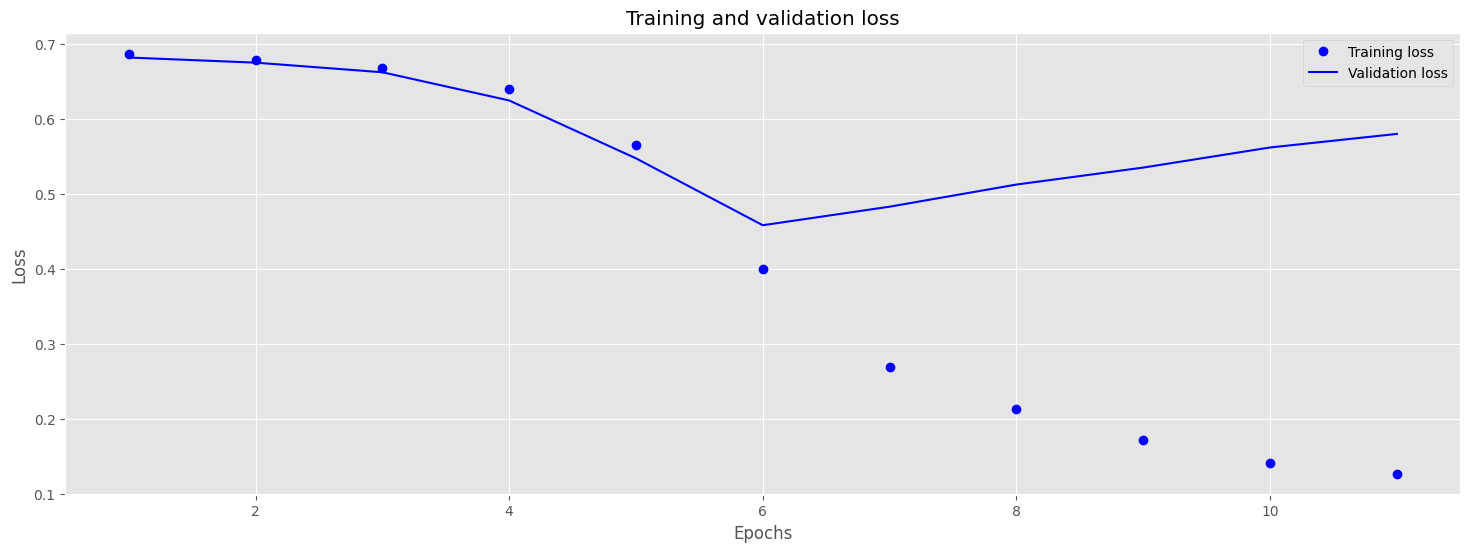

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

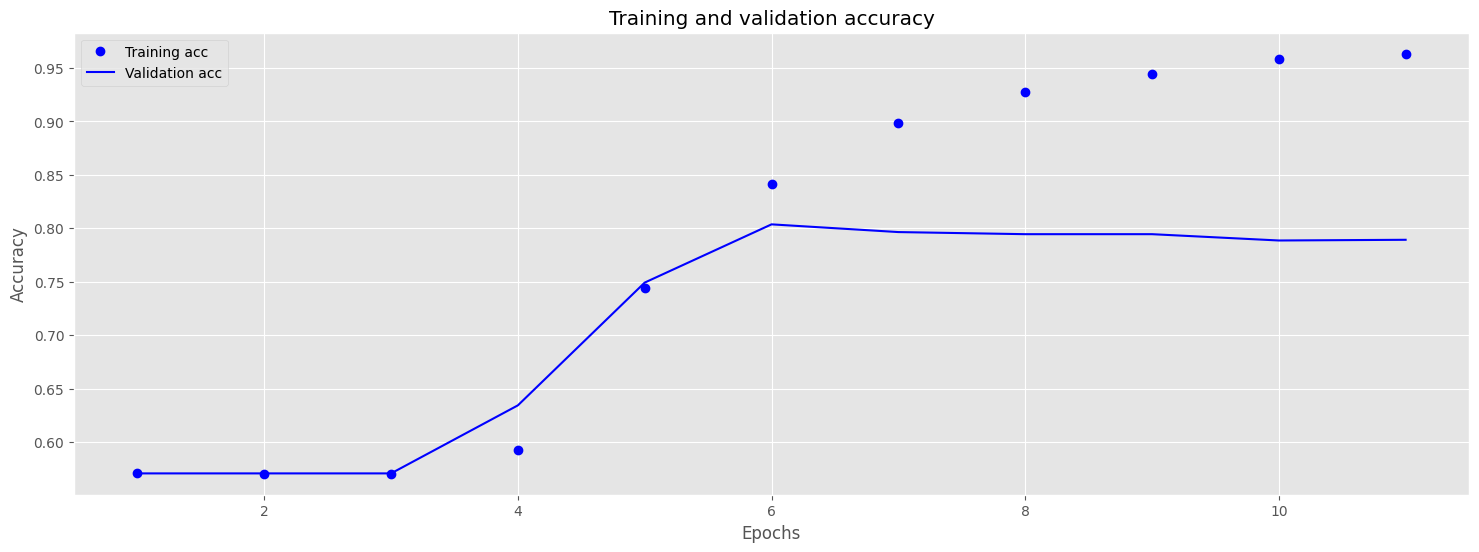

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(train[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 0.78486

102/102 [==============================] - 1s 3ms/step


# LSTM 한번만 나오는 단어 제거

In [ ]:
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)                                        
tokenizer.fit_on_texts(df['text'])                                
sequences = tokenizer.texts_to_sequences(df['text'])     

print(sequences[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 1354], [123, 1522, 1434, 2187, 665, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 142]]


In [ ]:
a = []
for i in range(len(sequences )):
    a.append(len(sequences [i]))
max_len = max(a)
print(max_len)
#가장 긴 tweet의 길이 : 26개의 단어

26


In [ ]:
train = pad_sequences(sequences , maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", train.shape)

훈련 데이터의 크기(shape): (10876, 26)


In [ ]:
vocab_size = len(word_to_index)
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22794


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train[:df_train.shape[0]], 
                                                                  df_train['target'].values, 
                                                                  test_size=0.2, 
                                                                  random_state=0, 
                                                                  stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3,          
)
]


history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           #그래프 보면서 에포크 늘려봤음 
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5696
Epoch 1: val_accuracy improved from -inf to 0.57058, saving model to checkpoint_path.keras
96/96 [==============================] - 18s 154ms/step - loss: 0.6874 - accuracy: 0.5696 - val_loss: 0.6821 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.5703
Epoch 2: val_accuracy did not improve from 0.57058
96/96 [==============================] - 5s 53ms/step - loss: 0.6769 - accuracy: 0.5703 - val_loss: 0.6722 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.5708
Epoch 3: val_accuracy improved from 0.57058 to 0.57518, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 36ms/step - loss: 0.6628 - accuracy: 0.5708 - val_loss: 0.6533 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 4/50
96/96 [=====================

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

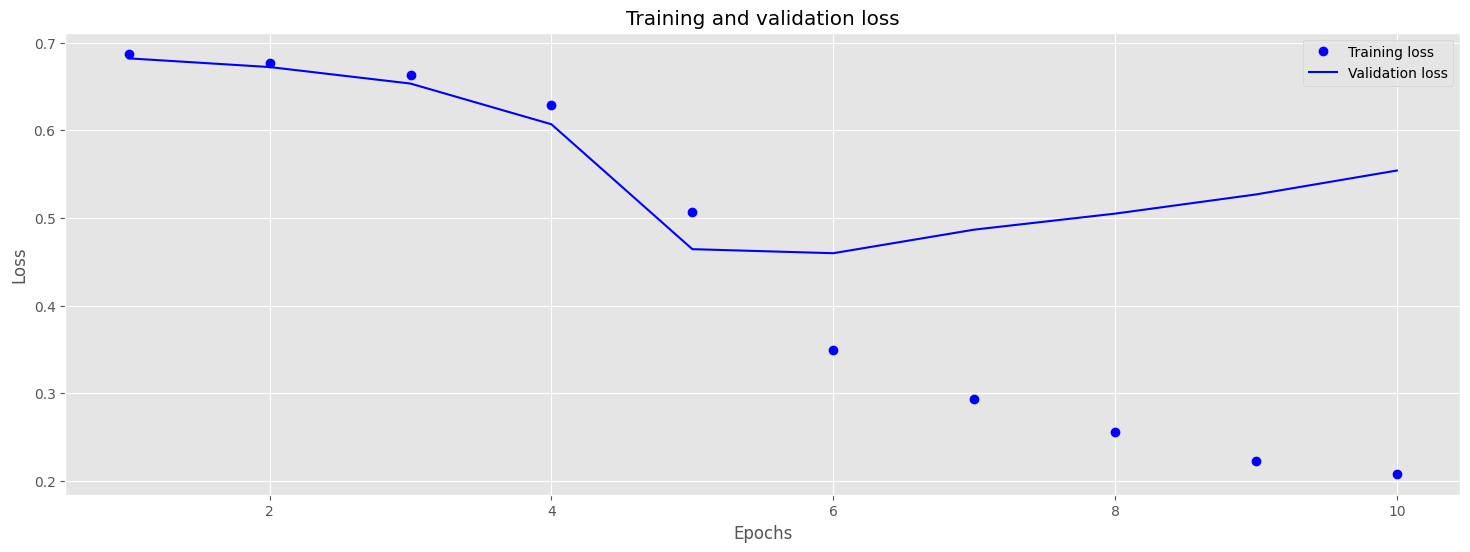

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

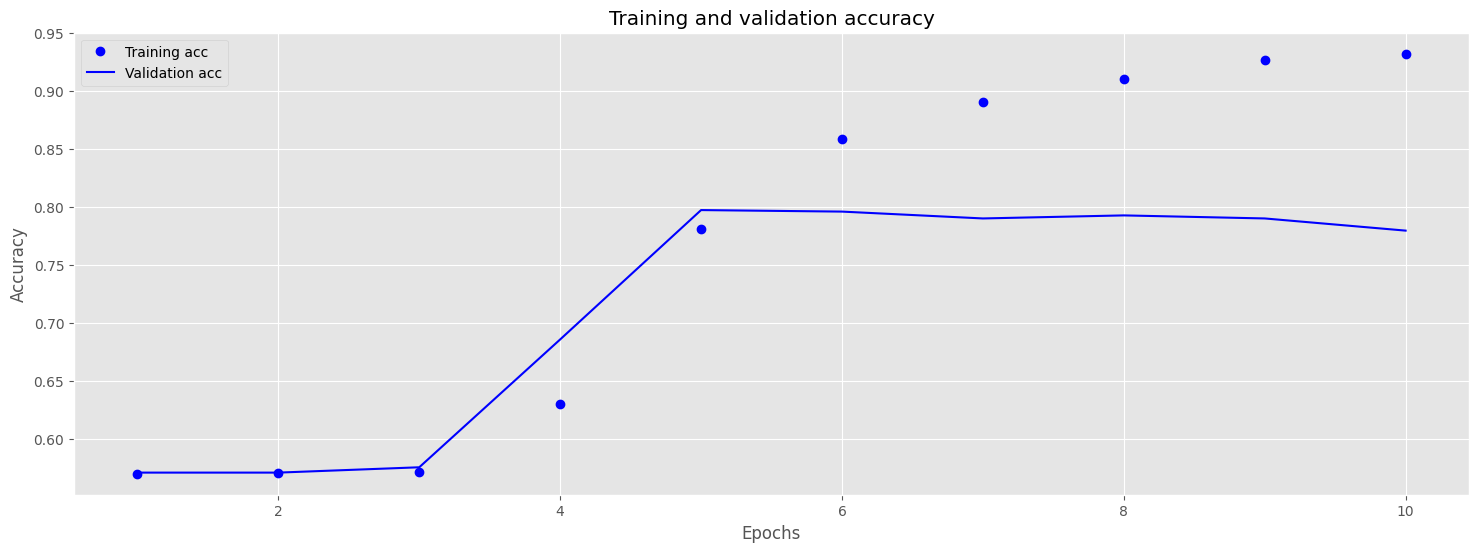

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(train[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 0.79742

102/102 [==============================] - 1s 3ms/step


# GLOVE

In [ ]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

#pre-trained word embedding download
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [ ]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    #100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
embedding_dict['described']
#임의의 단어의 임베딩 벡터

array([-0.77675  , -0.39544  , -0.23503  ,  0.12374  , -0.062412 ,
        0.16114  ,  0.41224  , -0.1183   , -0.24595  , -0.0042676,
       -0.46711  , -0.1773   ,  0.22936  , -0.15351  ,  0.19196  ,
        0.3456   ,  0.19291  , -0.48402  , -0.62981  , -0.05973  ,
        0.30394  , -0.20145  ,  0.12788  , -0.29756  ,  0.014653 ,
       -0.042935 , -0.097113 ,  0.043257 ,  0.02393  ,  0.73688  ,
        0.22381  ,  0.18879  , -0.30323  ,  0.012293 ,  0.29425  ,
        0.24309  ,  0.048583 ,  0.26707  , -0.056675 , -0.10544  ,
       -0.80896  ,  0.23054  ,  0.70457  ,  0.37263  , -0.036724 ,
       -0.23211  ,  0.12504  ,  0.044823 , -0.060565 , -0.14451  ,
        0.66952  , -0.42189  ,  0.94151  ,  0.78102  , -0.50328  ,
       -2.0984   , -0.18119  , -0.18671  ,  0.6576   ,  0.55676  ,
       -0.081965 ,  0.61956  , -0.18996  , -0.38323  ,  0.94778  ,
       -0.45197  ,  0.62815  ,  0.42958  ,  0.20367  ,  0.18164  ,
       -0.2055   ,  0.35146  , -0.19534  , -0.034256 ,  0.2947

In [ ]:
print('벡터의 차원 수 :',len(embedding_dict['described']))

벡터의 차원 수 : 100


In [ ]:
total_cnt - rare_cnt + 1

8487

In [ ]:
#tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)                  
tokenizer = Tokenizer()                        
tokenizer.fit_on_texts(df['text'])                                
sequences = tokenizer.texts_to_sequences(df['text'])     

print(sequences[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
a = []
for i in range(len(sequences )):
    a.append(len(sequences [i]))

max_len = max(a)
print(max_len)

28


In [ ]:
train = pad_sequences(sequences , maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", train.shape)

훈련 데이터의 크기(shape): (10876, 28)


In [ ]:
word_index=tokenizer.word_index
vocab_size = len(word_to_index)
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22794


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train[:df_train.shape[0]], 
                                                                  df_train['target'].values, 
                                                                  test_size=0.2, 
                                                                  random_state=0, 
                                                                  stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))

In [ ]:
for word,i in tqdm(word_index.items()):
    if i > vocab_size:
        continue
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 22794/22794 [00:00<00:00, 281593.59it/s]


In [ ]:
#print(tokenizer.word_index.items())

In [ ]:
print(embedding_dict['the'])

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

In [ ]:
embedding_matrix[2]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [ ]:
embedding_matrix.shape

(22794, 100)

In [ ]:
train[0][0:]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  642, 5761,
        761,  182,   82, 1873, 3684,   16], dtype=int32)

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 28, 100)           2279400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
91/96 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5484
Epoch 1: val_accuracy improved from -inf to 0.63953, saving model to checkpoint_path.keras
96/96 [==============================] - 8s 35ms/step - loss: 0.6833 - accuracy: 0.5532 - val_loss: 0.6575 - val_accuracy: 0.6395 - lr: 1.0000e-04
Epoch 2/50
90/96 [===========================>..] - ETA: 0s - loss: 0.6353 - accuracy: 0.6816
Epoch 2: val_accuracy improved from 0.63953 to 0.72882, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 22ms/step - loss: 0.6350 - accuracy: 0.6806 - val_loss: 0.5996 - val_accuracy: 0.7288 - lr: 1.0000e-04
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7580
Epoch 3: val_accuracy improved from 0.72882 to 0.78858, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 23ms/step - loss: 0.5563 - accuracy: 0.7580 - val_loss: 0.4981 - val_accuracy: 0.7886 - lr: 1.0000e-0

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

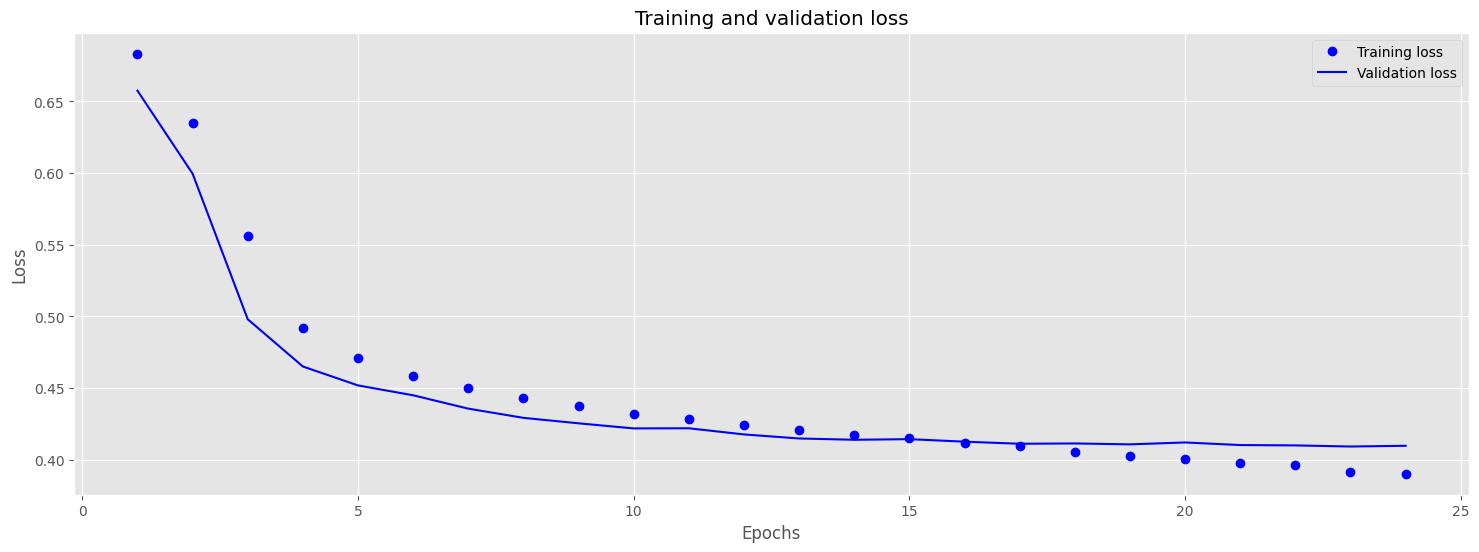

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

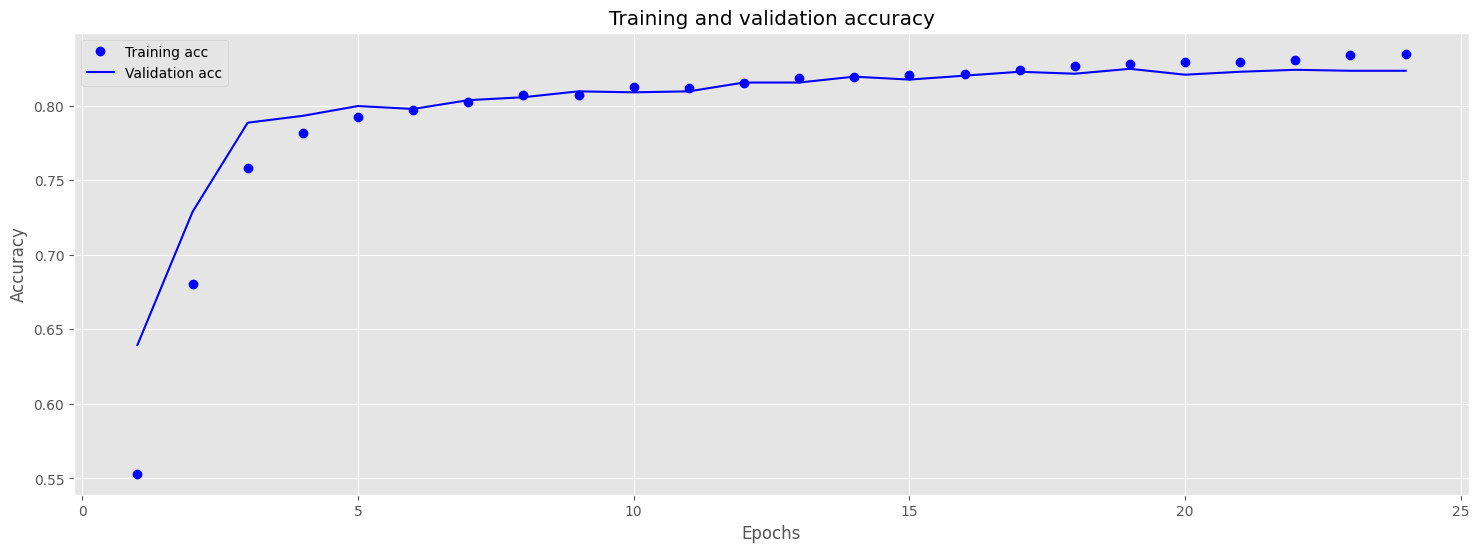

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 하이퍼파라미터 튜닝
# 학습률 
## - 1e-4(기존) : 0.82469
## 1e-5 : 0.70978
## 1e-3 : 0.82534  val_loss : 0.4099
## 5e-3 : 0.82469
## 5e-4 : 0.82534  val_loss: 0.4150

# 1

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

#optimzer=Adam(learning_rate=1e-4)
optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_809"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_809 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_807 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dense_2401 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
95/96 [============================>.] - ETA: 0s - loss: 0.6968 - accuracy: 0.4712
Epoch 1: val_accuracy improved from -inf to 0.47997, saving model to checkpoint_path.keras
96/96 [==============================] - 9s 38ms/step - loss: 0.6968 - accuracy: 0.4713 - val_loss: 0.6936 - val_accuracy: 0.4800 - lr: 1.0000e-05
Epoch 2/50
95/96 [============================>.] - ETA: 0s - loss: 0.6907 - accuracy: 0.5164
Epoch 2: val_accuracy improved from 0.47997 to 0.53775, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 23ms/step - loss: 0.6907 - accuracy: 0.5167 - val_loss: 0.6878 - val_accuracy: 0.5378 - lr: 1.0000e-05
Epoch 3/50
94/96 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5683
Epoch 3: val_accuracy improved from 0.53775 to 0.58372, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 32ms/step - loss: 0.6852 - accuracy: 0.5678 - val_loss: 0.6825 - val_accuracy: 0.5837 - lr: 1.0000e-0

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

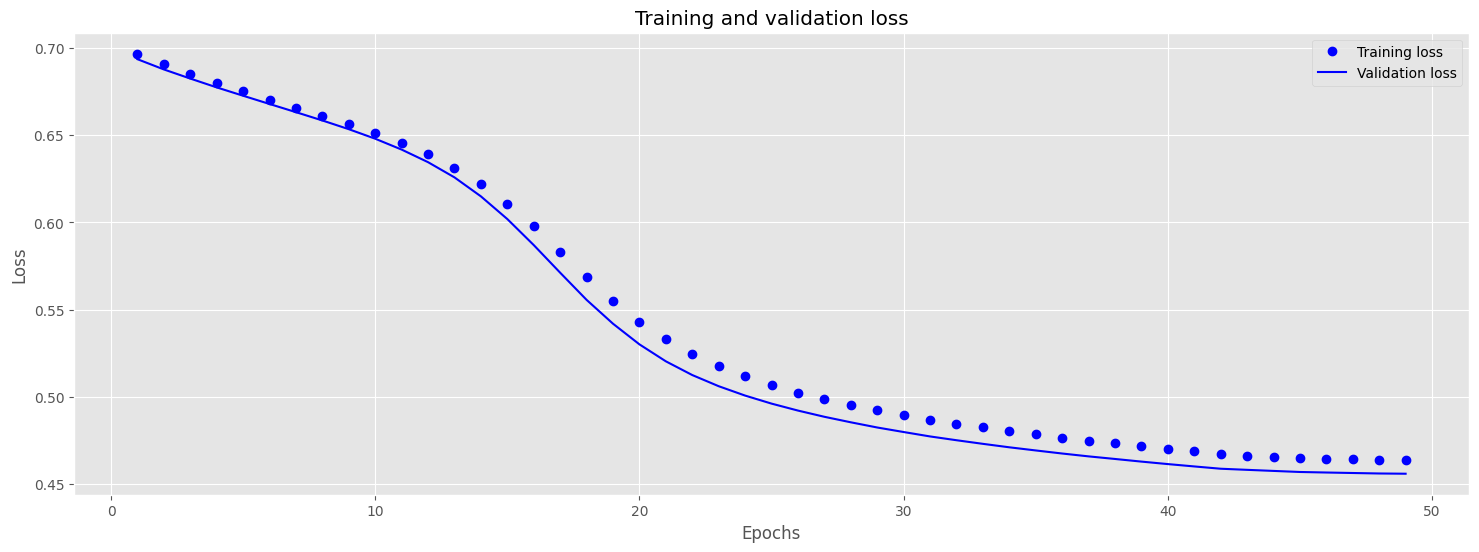

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

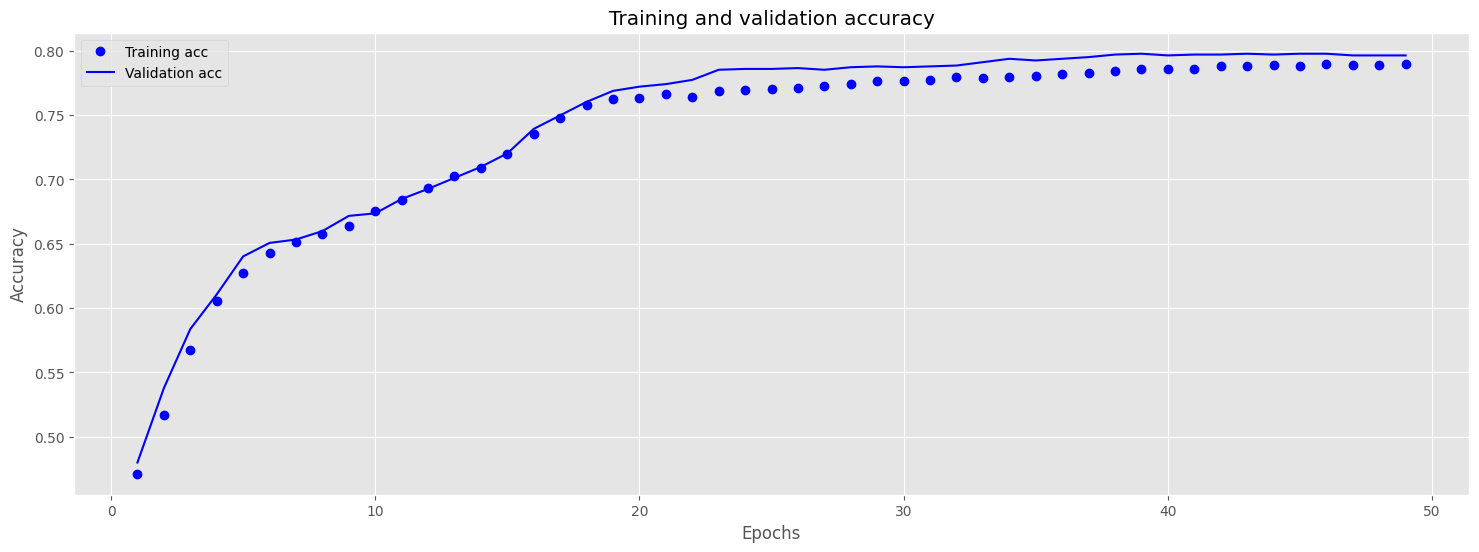

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 2

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

#optimzer=Adam(learning_rate=1e-5)
#optimzer=Adam(learning_rate=1e-4)
optimzer=Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

Exception ignored in: <function _xla_gc_callback at 0x7f24a9c89240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
model.summary()

Model: "sequential_810"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_810 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_808 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dense_2402 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
93/96 [============================>.] - ETA: 0s - loss: 0.5328 - accuracy: 0.7508
Epoch 1: val_accuracy improved from -inf to 0.81156, saving model to checkpoint_path.keras
96/96 [==============================] - 8s 41ms/step - loss: 0.5302 - accuracy: 0.7525 - val_loss: 0.4366 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 2/50
93/96 [============================>.] - ETA: 0s - loss: 0.4388 - accuracy: 0.8014
Epoch 2: val_accuracy improved from 0.81156 to 0.82141, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 28ms/step - loss: 0.4388 - accuracy: 0.8010 - val_loss: 0.4200 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 3/50
95/96 [============================>.] - ETA: 0s - loss: 0.4174 - accuracy: 0.8158
Epoch 3: val_accuracy improved from 0.82141 to 0.82469, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 22ms/step - loss: 0.4178 - accuracy: 0.8156 - val_loss: 0.4137 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 4/50

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

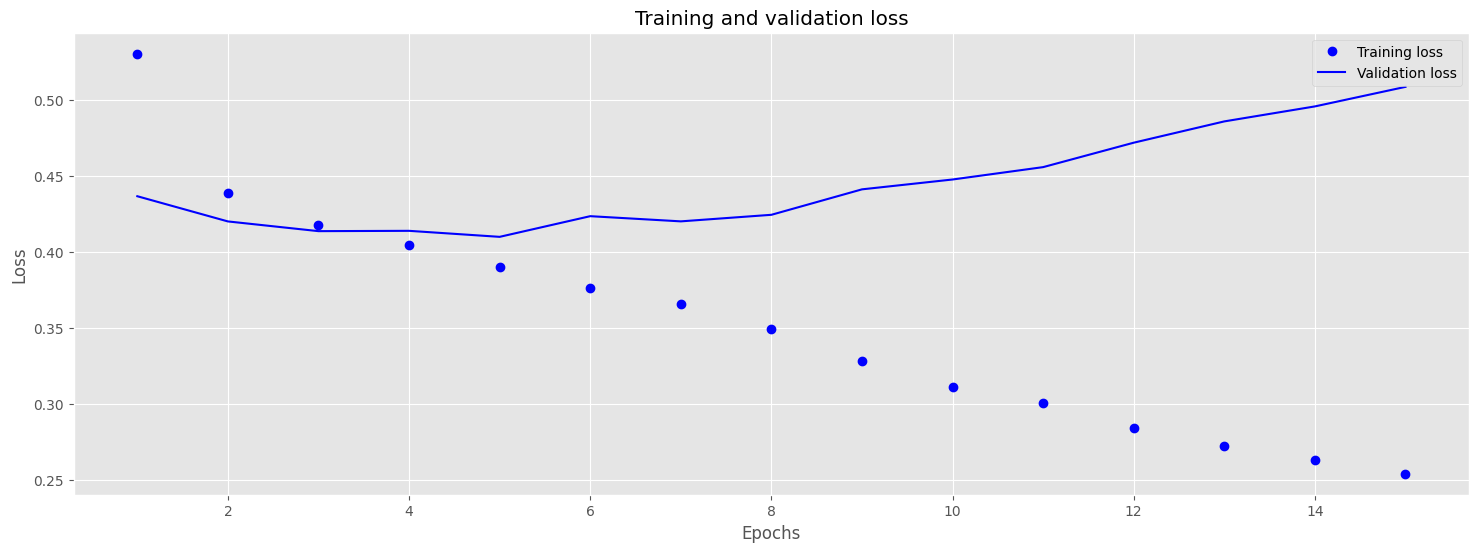

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

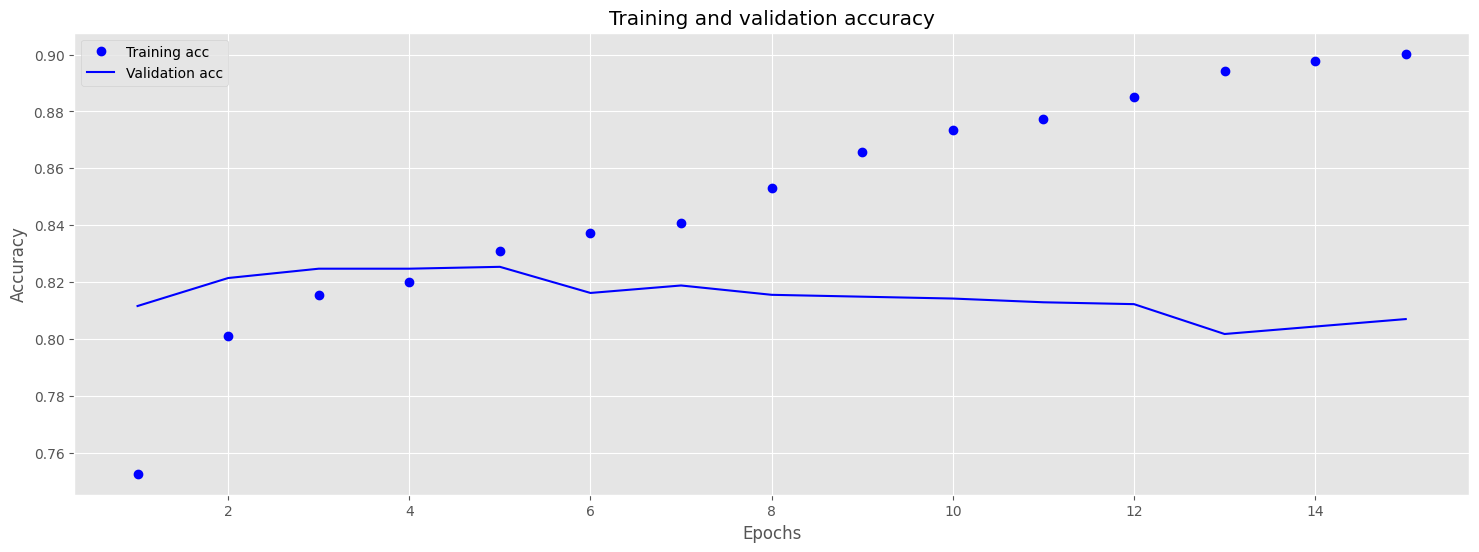

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 3

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

#optimzer=Adam(learning_rate=1e-5)
#optimzer=Adam(learning_rate=1e-4)
#optimzer=Adam(learning_rate=1e-3)
optimzer=Adam(learning_rate=5e-3)


model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_811"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_811 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_809 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dense_2403 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
94/96 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.7801
Epoch 1: val_accuracy improved from -inf to 0.81812, saving model to checkpoint_path.keras
96/96 [==============================] - 10s 45ms/step - loss: 0.4758 - accuracy: 0.7811 - val_loss: 0.4282 - val_accuracy: 0.8181 - lr: 0.0050
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8172
Epoch 2: val_accuracy improved from 0.81812 to 0.82272, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 22ms/step - loss: 0.4200 - accuracy: 0.8172 - val_loss: 0.4276 - val_accuracy: 0.8227 - lr: 0.0050
Epoch 3/50
90/96 [===========================>..] - ETA: 0s - loss: 0.3959 - accuracy: 0.8326
Epoch 3: val_accuracy did not improve from 0.82272
96/96 [==============================] - 1s 9ms/step - loss: 0.3951 - accuracy: 0.8325 - val_loss: 0.4339 - val_accuracy: 0.8076 - lr: 0.0050
Epoch 4/50
91/96 [===========================>..] - E

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

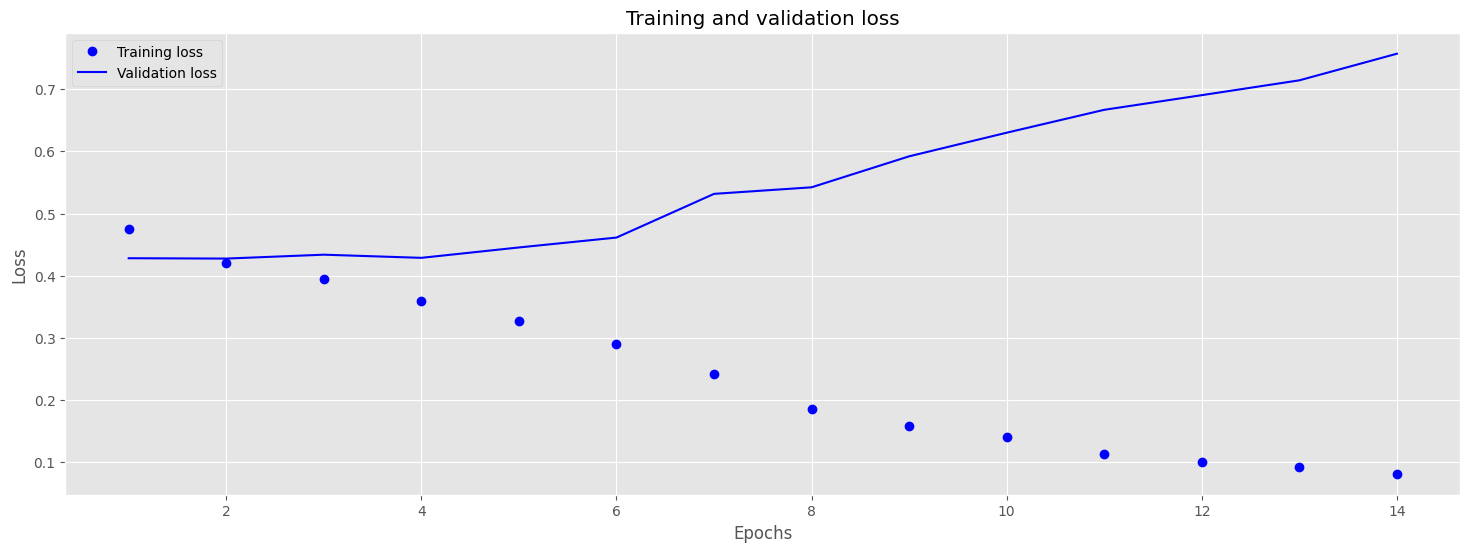

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

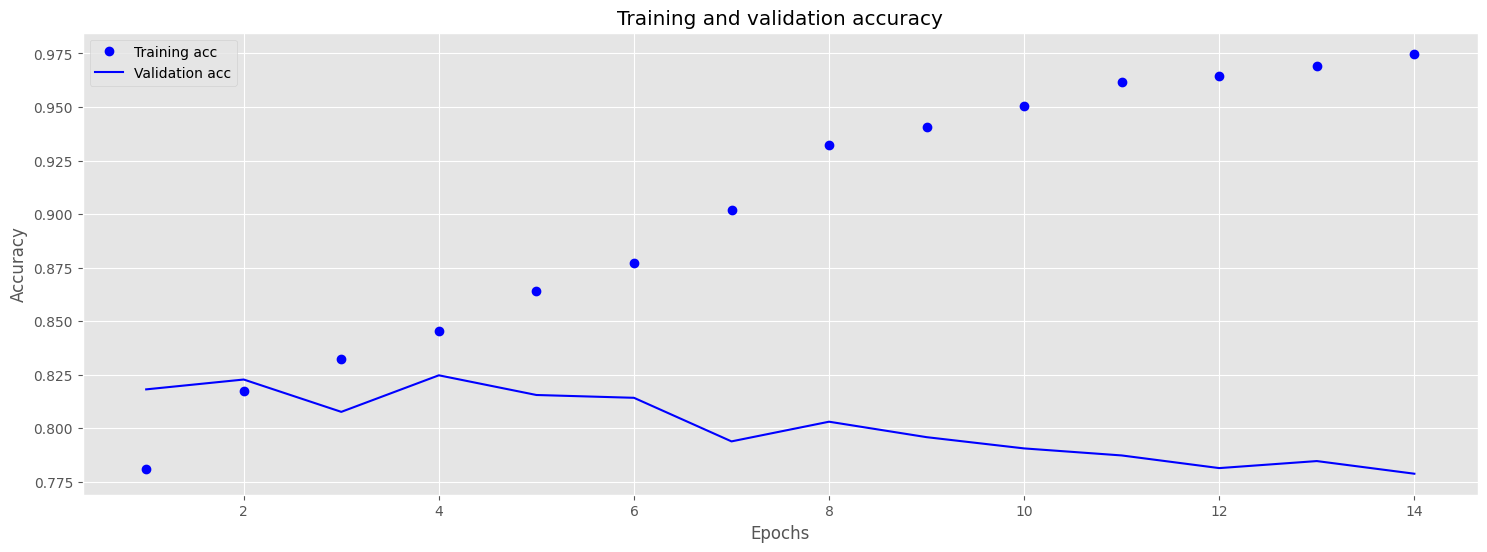

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 4

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

#optimzer=Adam(learning_rate=1e-5)
#optimzer=Adam(learning_rate=1e-4)
#optimzer=Adam(learning_rate=1e-3)
#optimzer=Adam(learning_rate=5e-3)
optimzer=Adam(learning_rate=5e-4)


model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_816"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_816 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_814 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dense_2408 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
93/96 [============================>.] - ETA: 0s - loss: 0.5813 - accuracy: 0.7063
Epoch 1: val_accuracy improved from -inf to 0.79317, saving model to checkpoint_path.keras
96/96 [==============================] - 13s 66ms/step - loss: 0.5793 - accuracy: 0.7079 - val_loss: 0.4650 - val_accuracy: 0.7932 - lr: 5.0000e-04
Epoch 2/50
92/96 [===========================>..] - ETA: 0s - loss: 0.4591 - accuracy: 0.7959
Epoch 2: val_accuracy improved from 0.79317 to 0.81812, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 35ms/step - loss: 0.4603 - accuracy: 0.7954 - val_loss: 0.4315 - val_accuracy: 0.8181 - lr: 5.0000e-04
Epoch 3/50
95/96 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.8066
Epoch 3: val_accuracy improved from 0.81812 to 0.82272, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 25ms/step - loss: 0.4371 - accuracy: 0.8064 - val_loss: 0.4227 - val_accuracy: 0.8227 - lr: 5.0000e-

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

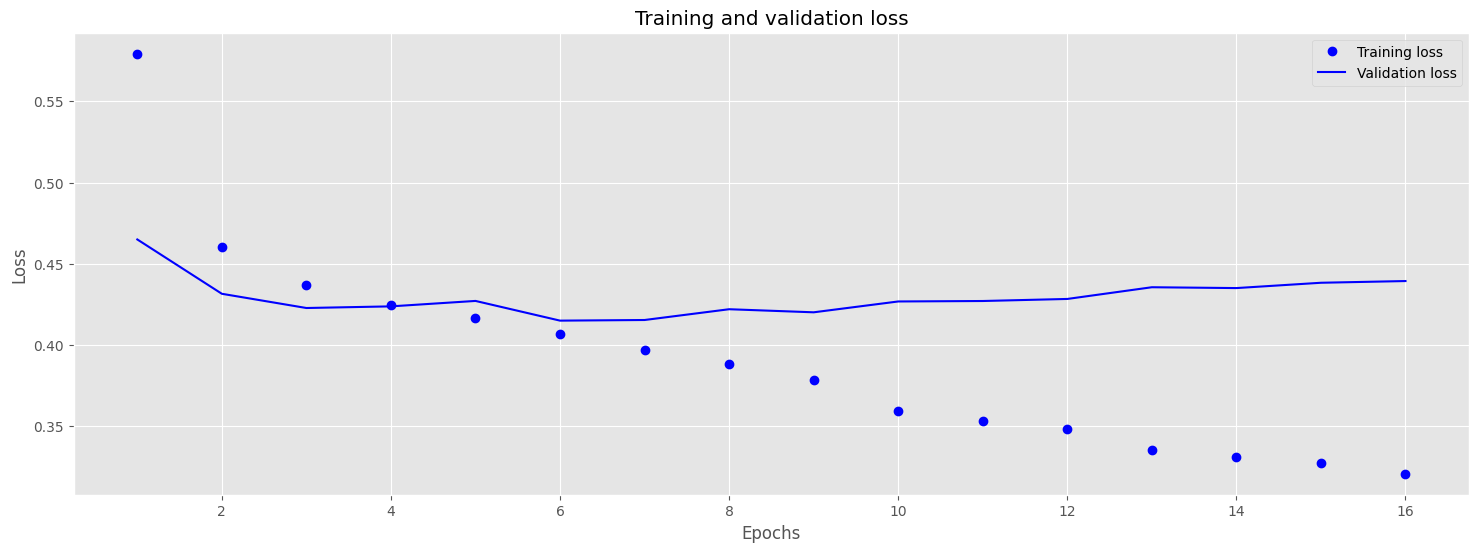

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

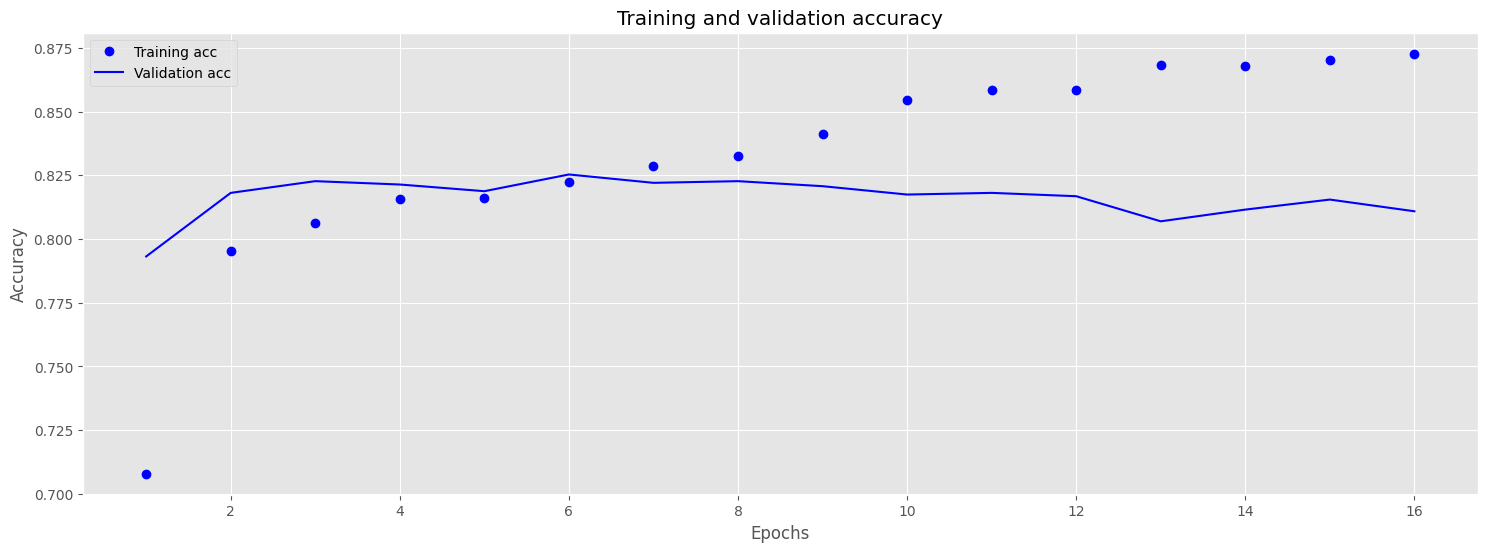

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 은닉층 늘리기 -> 안하는 게 나아보임

## Dense 256추가

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


optimizer=Adam(learning_rate=1e-3)


model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_818"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_818 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_816 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dense_2411 (Dense)          (None, 256)               16640     
                                                                 
 dense_2412 (Dense)          (None, 1)                 257       
                                                                 
Total params: 2,330,345
Trainable params: 50,945
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.7619
Epoch 1: val_accuracy improved from -inf to 0.81090, saving model to checkpoint_path.keras
96/96 [==============================] - 9s 41ms/step - loss: 0.5131 - accuracy: 0.7619 - val_loss: 0.4371 - val_accuracy: 0.8109 - lr: 0.0010
Epoch 2/50
94/96 [============================>.] - ETA: 0s - loss: 0.4338 - accuracy: 0.8045
Epoch 2: val_accuracy did not improve from 0.81090
96/96 [==============================] - 1s 8ms/step - loss: 0.4342 - accuracy: 0.8049 - val_loss: 0.4318 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 3/50
93/96 [============================>.] - ETA: 0s - loss: 0.4212 - accuracy: 0.8130
Epoch 3: val_accuracy improved from 0.81090 to 0.82337, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 34ms/step - loss: 0.4178 - accuracy: 0.8151 - val_loss: 0.4216 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 4/50
95/96 [============================>.] - ET

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

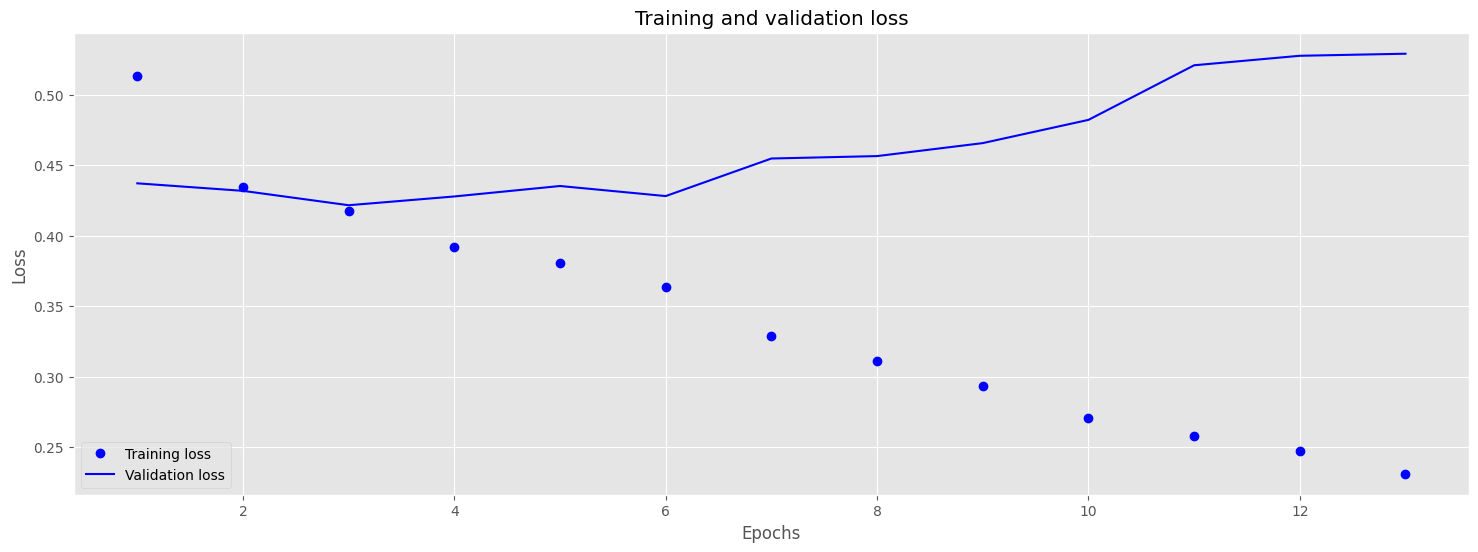

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

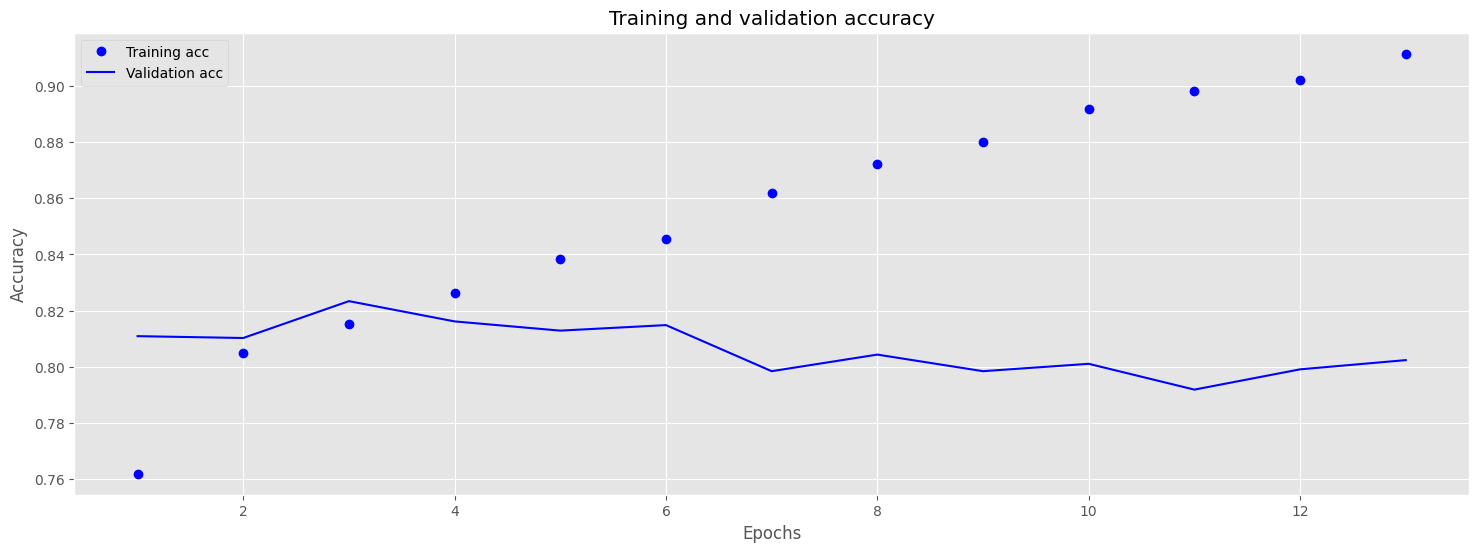

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Dense 64추가

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


optimizer=Adam(learning_rate=1e-3)


model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_819"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_819 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_817 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dense_2413 (Dense)          (None, 256)               16640     
                                                                 
 dense_2414 (Dense)          (None, 64)                16448     
                                                                 
 dense_2415 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,346,601
Trainable params: 67,201
Non-trainable params: 2,279,400
_____________________________________

In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
92/96 [===========================>..] - ETA: 0s - loss: 0.5203 - accuracy: 0.7490
Epoch 1: val_accuracy improved from -inf to 0.81812, saving model to checkpoint_path.keras
96/96 [==============================] - 9s 44ms/step - loss: 0.5183 - accuracy: 0.7502 - val_loss: 0.4400 - val_accuracy: 0.8181 - lr: 0.0010
Epoch 2/50
95/96 [============================>.] - ETA: 0s - loss: 0.4287 - accuracy: 0.8069
Epoch 2: val_accuracy did not improve from 0.81812
96/96 [==============================] - 1s 12ms/step - loss: 0.4289 - accuracy: 0.8067 - val_loss: 0.4264 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 3/50
93/96 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8191
Epoch 3: val_accuracy did not improve from 0.81812
96/96 [==============================] - 1s 11ms/step - loss: 0.4051 - accuracy: 0.8190 - val_loss: 0.4268 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 4/50
95/96 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8314
Ep

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

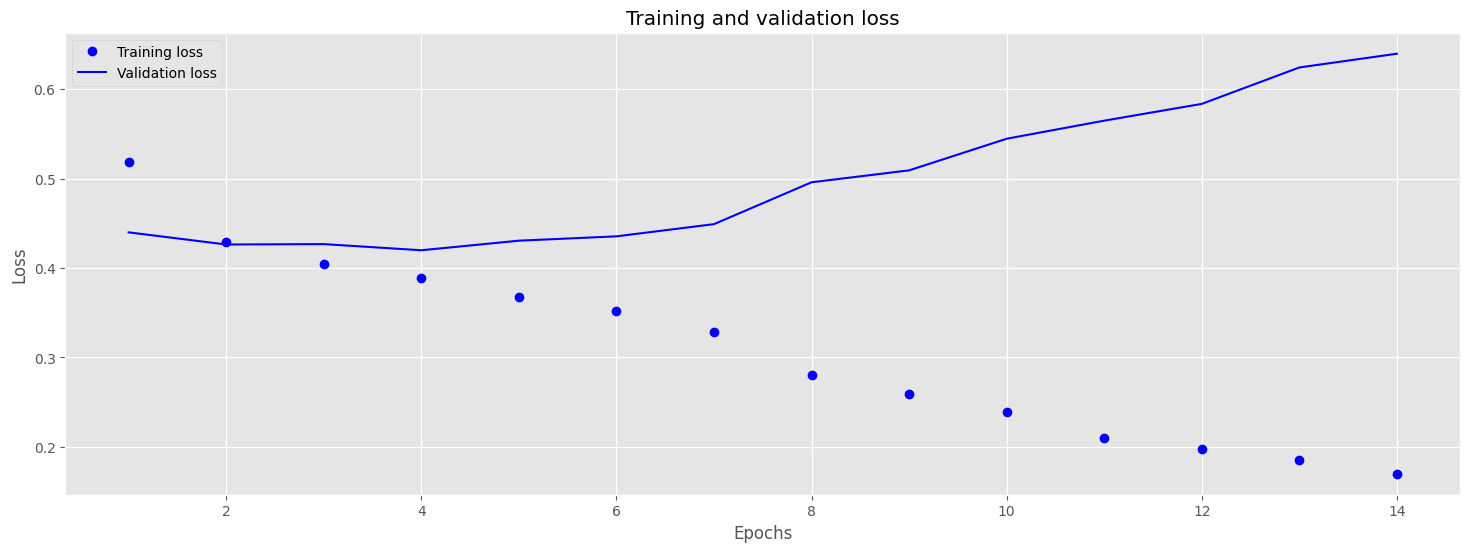

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

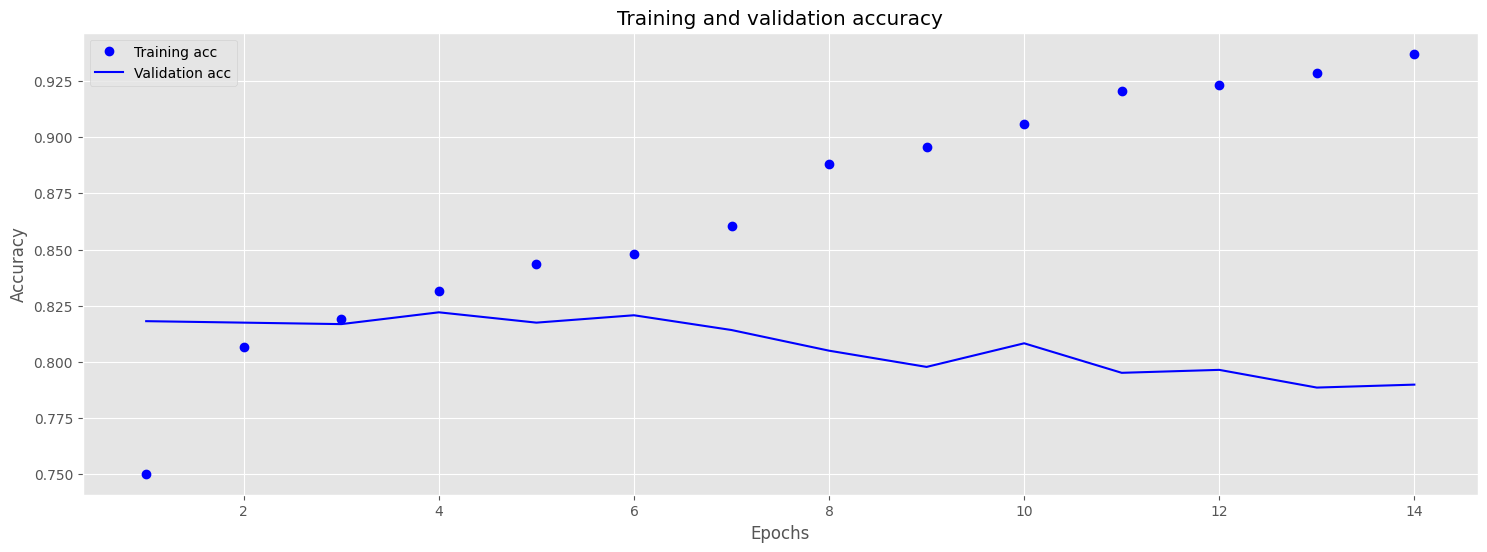

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 드롭아웃 추가 -> 0.5가 젤 좋았음

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


optimizer=Adam(learning_rate=1e-3)


model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_821"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_821 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_819 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dropout_800 (Dropout)       (None, 64)                0         
                                                                 
 dense_2416 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
92/96 [===========================>..] - ETA: 0s - loss: 0.5282 - accuracy: 0.7488
Epoch 1: val_accuracy improved from -inf to 0.79842, saving model to checkpoint_path.keras
96/96 [==============================] - 9s 38ms/step - loss: 0.5267 - accuracy: 0.7506 - val_loss: 0.4517 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 2/50
93/96 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.8076
Epoch 2: val_accuracy improved from 0.79842 to 0.81878, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 23ms/step - loss: 0.4399 - accuracy: 0.8077 - val_loss: 0.4225 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.8144
Epoch 3: val_accuracy improved from 0.81878 to 0.82272, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 23ms/step - loss: 0.4224 - accuracy: 0.8144 - val_loss: 0.4181 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/50

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

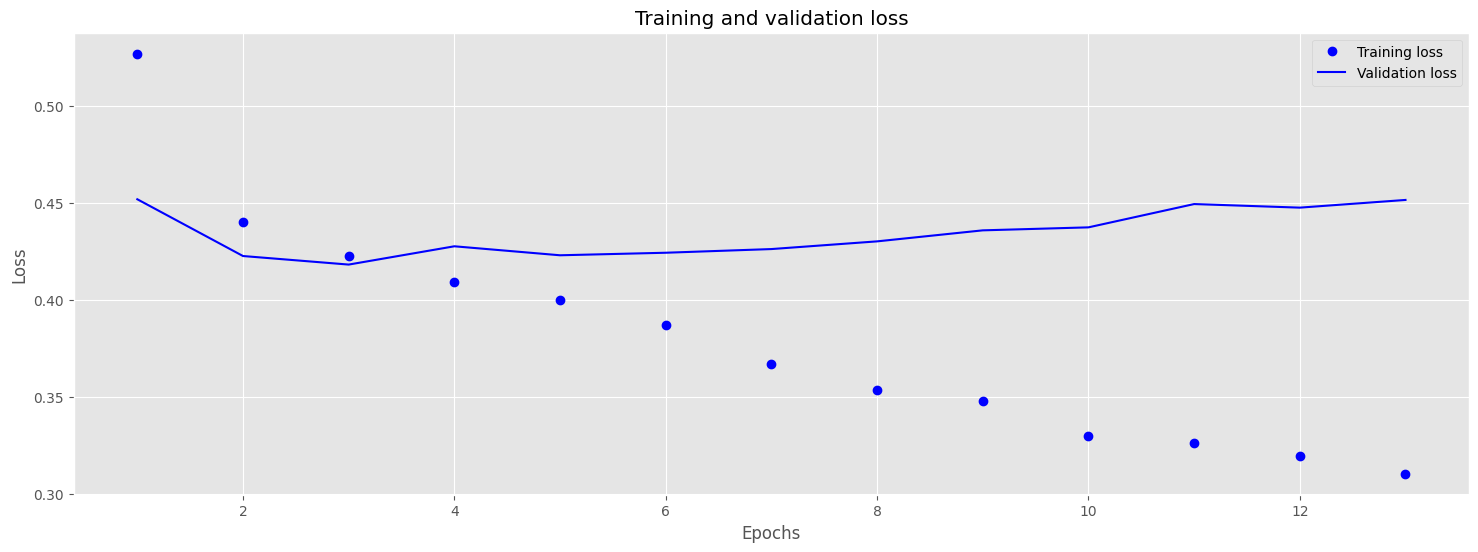

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

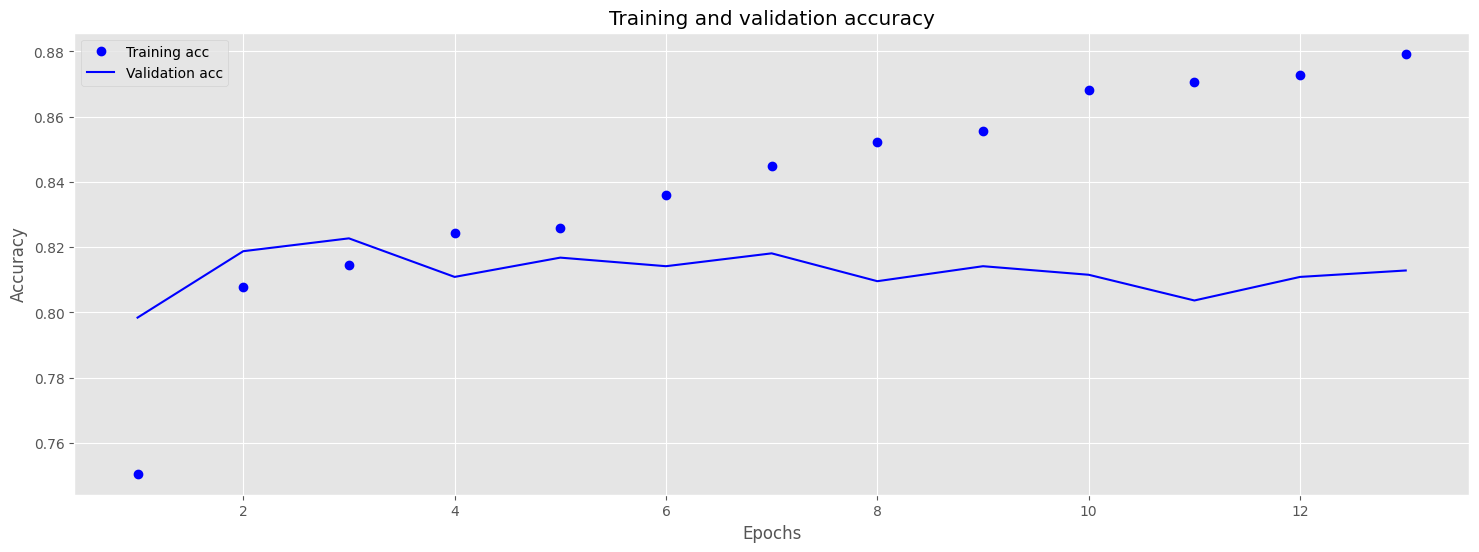

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


optimizer=Adam(learning_rate=1e-3)


model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_822"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_822 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_820 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dropout_801 (Dropout)       (None, 64)                0         
                                                                 
 dense_2417 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
94/96 [============================>.] - ETA: 0s - loss: 0.5325 - accuracy: 0.7448
Epoch 1: val_accuracy improved from -inf to 0.81681, saving model to checkpoint_path.keras
96/96 [==============================] - 10s 65ms/step - loss: 0.5335 - accuracy: 0.7445 - val_loss: 0.4380 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 2/50
95/96 [============================>.] - ETA: 0s - loss: 0.4501 - accuracy: 0.8026
Epoch 2: val_accuracy improved from 0.81681 to 0.81747, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 23ms/step - loss: 0.4512 - accuracy: 0.8020 - val_loss: 0.4167 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8067
Epoch 3: val_accuracy improved from 0.81747 to 0.82206, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 22ms/step - loss: 0.4318 - accuracy: 0.8067 - val_loss: 0.4149 - val_accuracy: 0.8221 - lr: 0.0010
Epoch 4/5

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

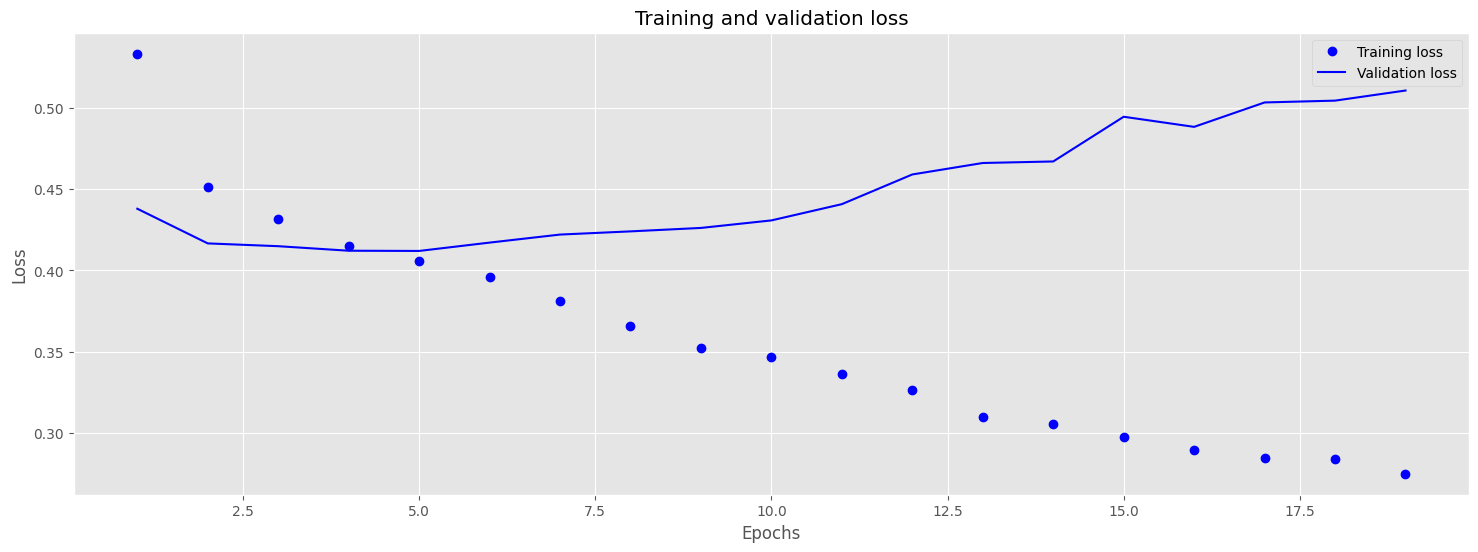

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

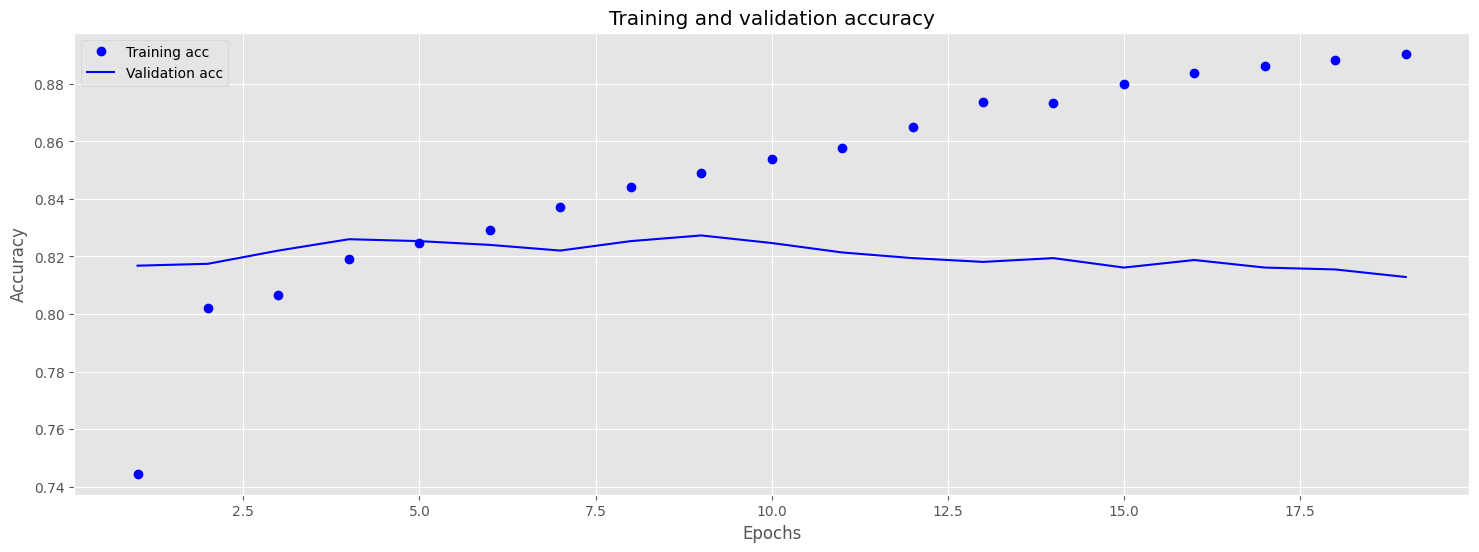

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))


optimizer=Adam(learning_rate=1e-3)


model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_823"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_823 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_821 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dropout_802 (Dropout)       (None, 64)                0         
                                                                 
 dense_2418 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
91/96 [===========================>..] - ETA: 0s - loss: 0.5349 - accuracy: 0.7399
Epoch 1: val_accuracy improved from -inf to 0.80630, saving model to checkpoint_path.keras
96/96 [==============================] - 8s 38ms/step - loss: 0.5305 - accuracy: 0.7430 - val_loss: 0.4339 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 2/50
95/96 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.8008
Epoch 2: val_accuracy improved from 0.80630 to 0.81418, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 22ms/step - loss: 0.4477 - accuracy: 0.8010 - val_loss: 0.4250 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 3/50
95/96 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8146
Epoch 3: val_accuracy did not improve from 0.81418
96/96 [==============================] - 1s 8ms/step - loss: 0.4277 - accuracy: 0.8148 - val_loss: 0.4163 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 4/50
94/96 [============================>.] - ET

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

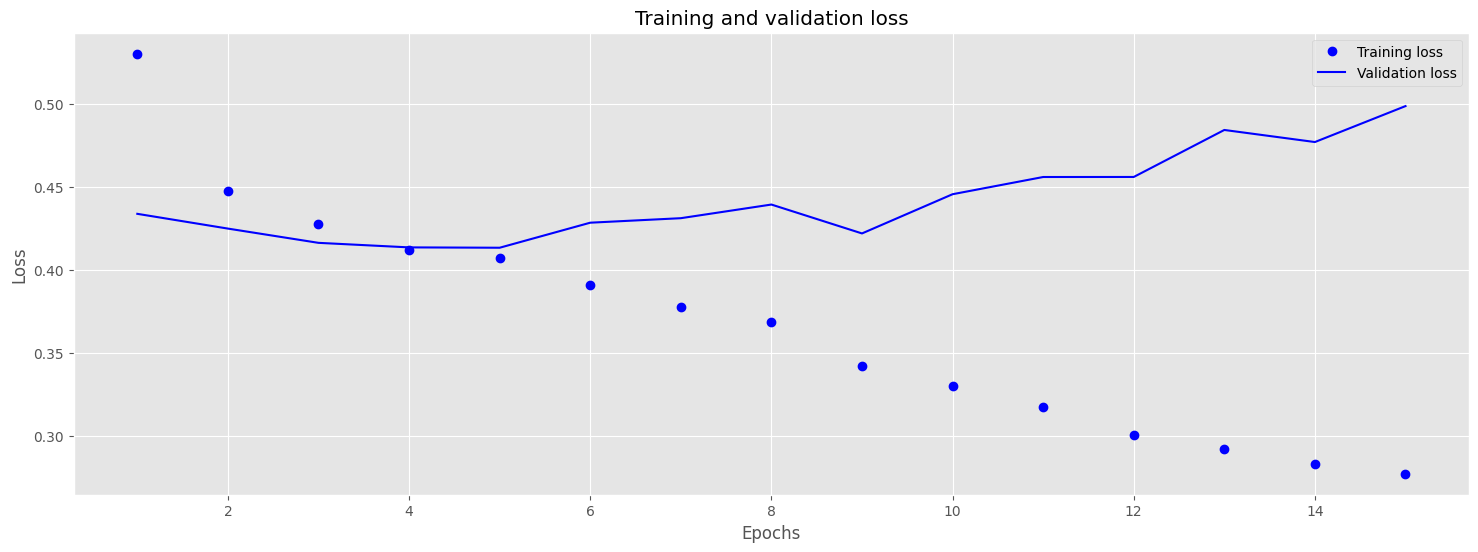

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

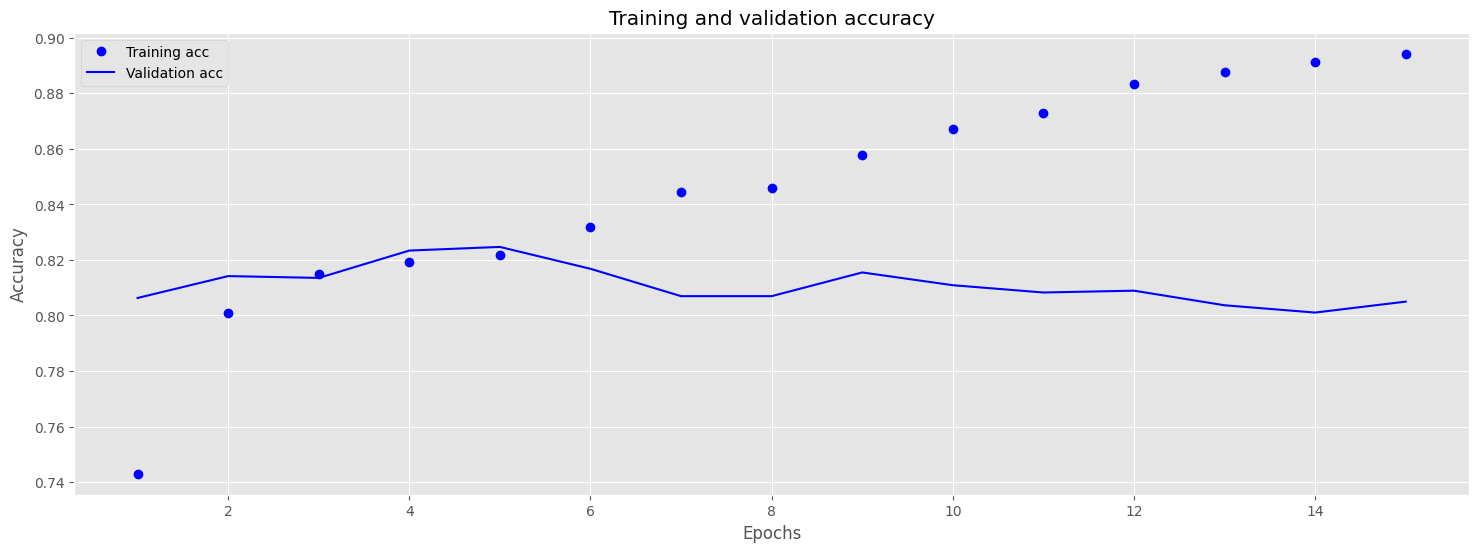

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


optimizer=Adam(learning_rate=1e-3)


model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_824"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_824 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_822 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dropout_803 (Dropout)       (None, 64)                0         
                                                                 
 dense_2419 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
93/96 [============================>.] - ETA: 0s - loss: 0.5217 - accuracy: 0.7584
Epoch 1: val_accuracy improved from -inf to 0.81090, saving model to checkpoint_path.keras
96/96 [==============================] - 10s 42ms/step - loss: 0.5217 - accuracy: 0.7575 - val_loss: 0.4334 - val_accuracy: 0.8109 - lr: 0.0010
Epoch 2/50
94/96 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.8060
Epoch 2: val_accuracy improved from 0.81090 to 0.81944, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 29ms/step - loss: 0.4412 - accuracy: 0.8057 - val_loss: 0.4221 - val_accuracy: 0.8194 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8151
Epoch 3: val_accuracy improved from 0.81944 to 0.82337, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 30ms/step - loss: 0.4207 - accuracy: 0.8151 - val_loss: 0.4191 - val_accuracy: 0.8234 - lr: 0.0010
Epoch 4/5

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

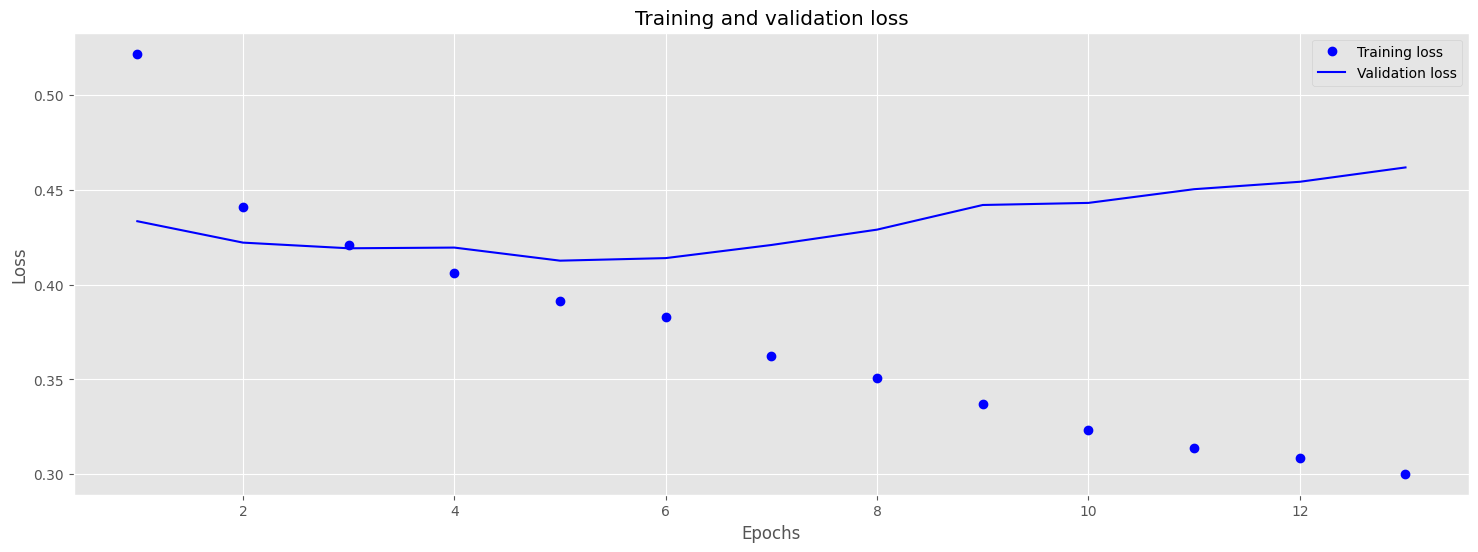

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

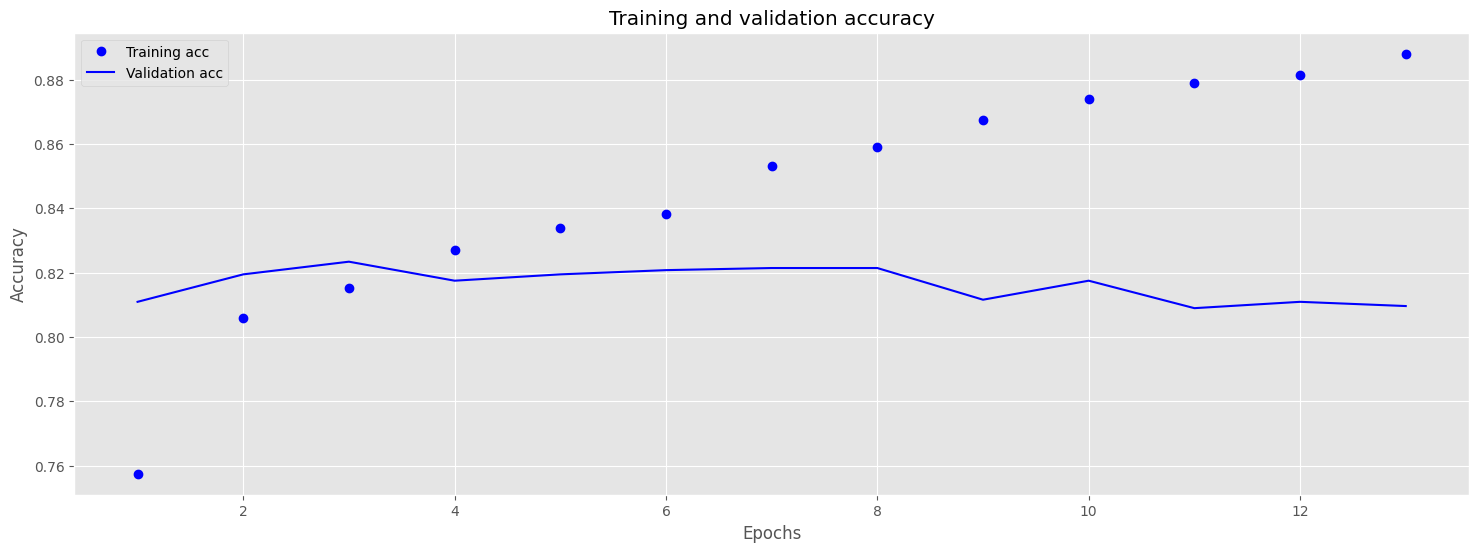

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 배치사이즈

# 32

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_825"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_825 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_823 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dropout_804 (Dropout)       (None, 64)                0         
                                                                 
 dense_2420 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=32, 
                    callbacks = callbacks_list)

Epoch 1/50
188/191 [============================>.] - ETA: 0s - loss: 0.5273 - accuracy: 0.7395
Epoch 1: val_accuracy improved from -inf to 0.80105, saving model to checkpoint_path.keras
191/191 [==============================] - 10s 26ms/step - loss: 0.5259 - accuracy: 0.7406 - val_loss: 0.4453 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 2/50
188/191 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.8059
Epoch 2: val_accuracy improved from 0.80105 to 0.82075, saving model to checkpoint_path.keras
191/191 [==============================] - 6s 32ms/step - loss: 0.4429 - accuracy: 0.8062 - val_loss: 0.4233 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 3/50
189/191 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8188
Epoch 3: val_accuracy did not improve from 0.82075
191/191 [==============================] - 2s 11ms/step - loss: 0.4213 - accuracy: 0.8184 - val_loss: 0.4172 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 4/50
186/191 [====================

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

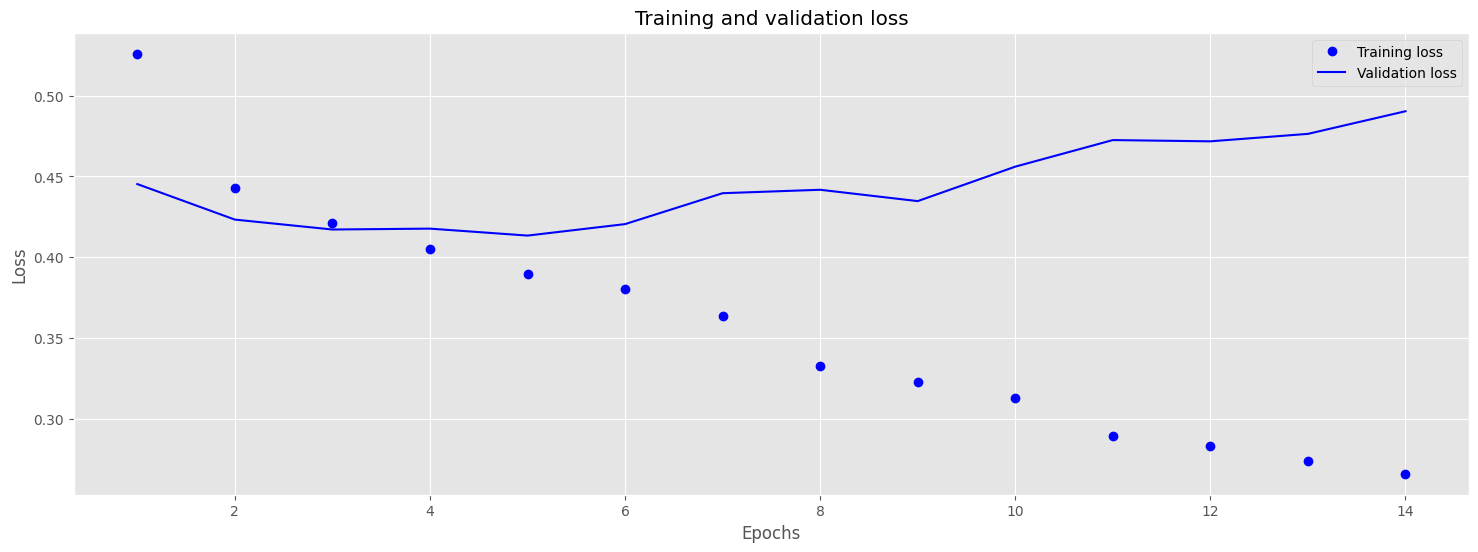

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

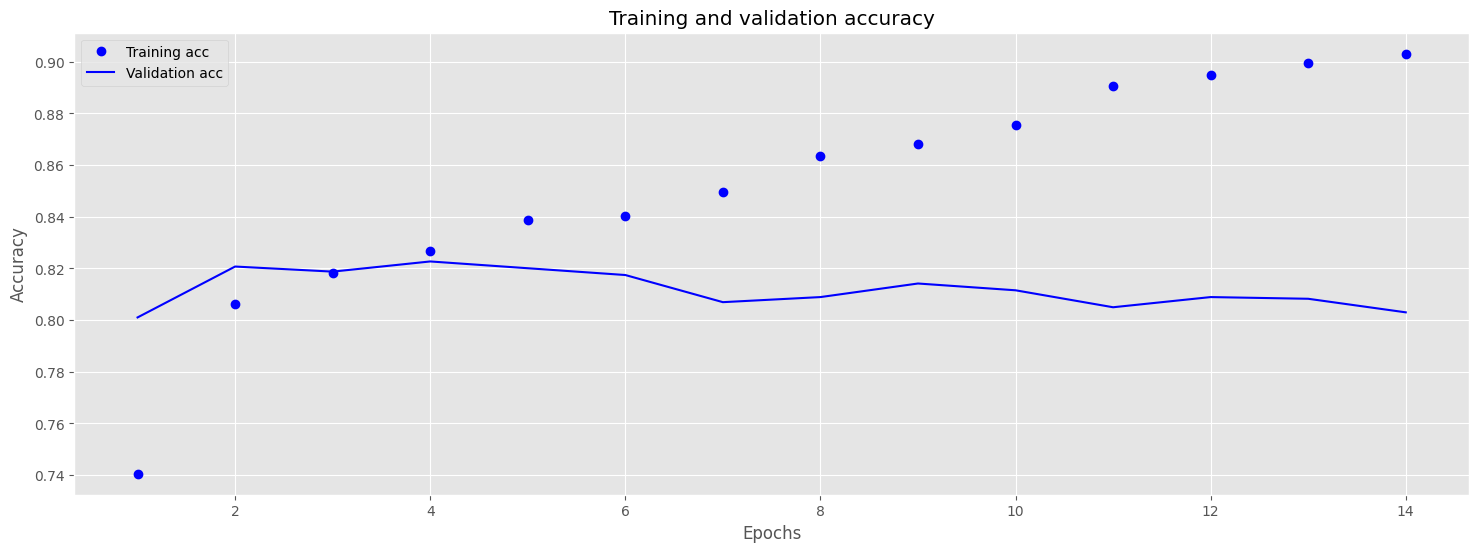

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 128

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=10                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_826"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_826 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_824 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dropout_805 (Dropout)       (None, 64)                0         
                                                                 
 dense_2421 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=128, 
                    callbacks = callbacks_list)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.7038
Epoch 1: val_accuracy improved from -inf to 0.78923, saving model to checkpoint_path.keras
48/48 [==============================] - 8s 80ms/step - loss: 0.5851 - accuracy: 0.7038 - val_loss: 0.4710 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 2/50
41/48 [========================>.....] - ETA: 0s - loss: 0.4658 - accuracy: 0.7944
Epoch 2: val_accuracy improved from 0.78923 to 0.81812, saving model to checkpoint_path.keras
48/48 [==============================] - 2s 39ms/step - loss: 0.4635 - accuracy: 0.7952 - val_loss: 0.4320 - val_accuracy: 0.8181 - lr: 0.0010
Epoch 3/50
46/48 [===========================>..] - ETA: 0s - loss: 0.4456 - accuracy: 0.8084
Epoch 3: val_accuracy did not improve from 0.81812
48/48 [==============================] - 0s 9ms/step - loss: 0.4437 - accuracy: 0.8092 - val_loss: 0.4233 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - ET

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

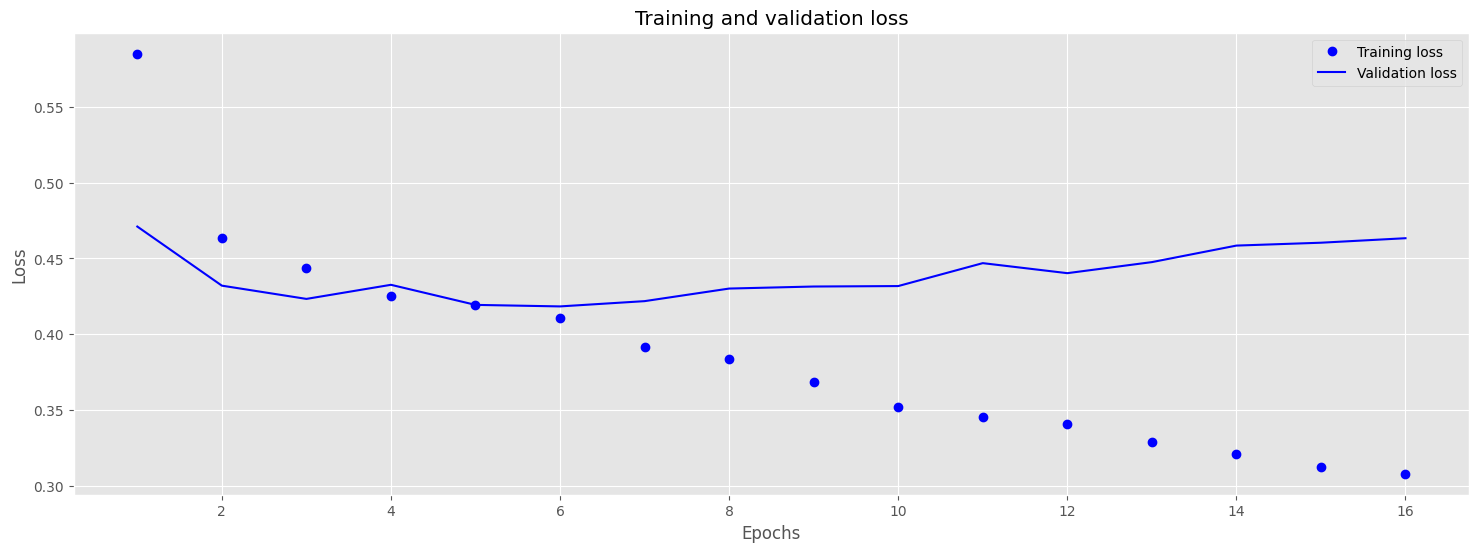

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

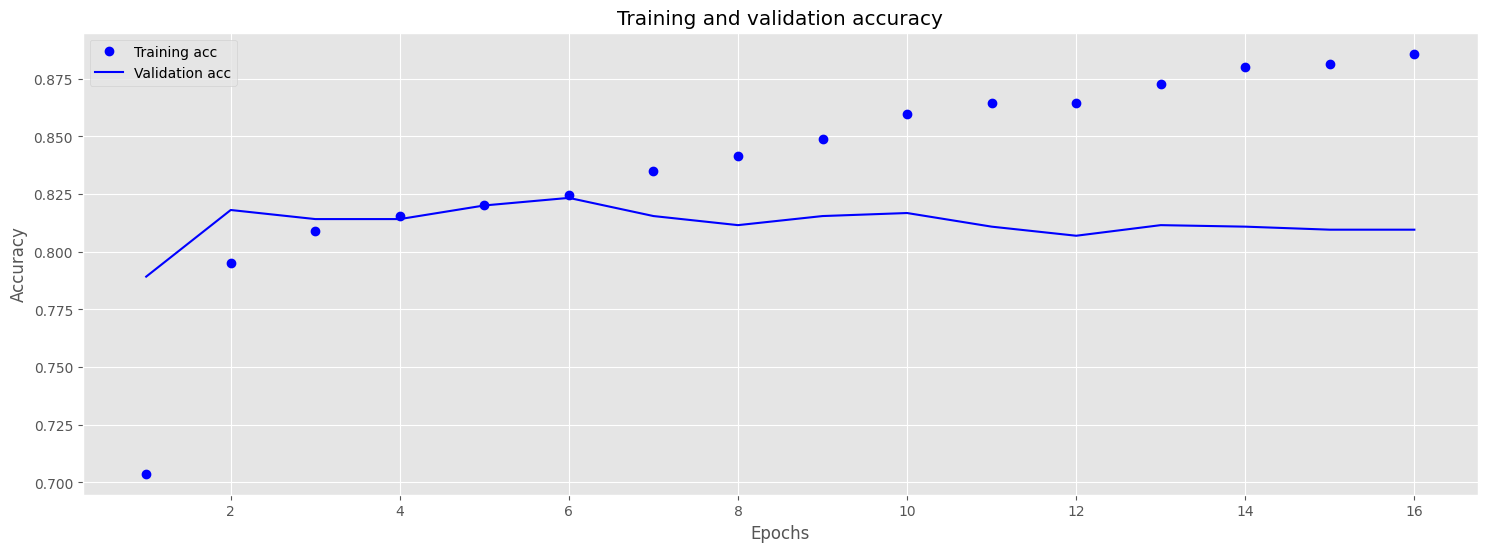

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 튜닝 완. GLOVE

In [ ]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

#pre-trained word embedding download
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [ ]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    #100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
embedding_dict['described']
#임의의 단어의 임베딩 벡터

array([-0.77675  , -0.39544  , -0.23503  ,  0.12374  , -0.062412 ,
        0.16114  ,  0.41224  , -0.1183   , -0.24595  , -0.0042676,
       -0.46711  , -0.1773   ,  0.22936  , -0.15351  ,  0.19196  ,
        0.3456   ,  0.19291  , -0.48402  , -0.62981  , -0.05973  ,
        0.30394  , -0.20145  ,  0.12788  , -0.29756  ,  0.014653 ,
       -0.042935 , -0.097113 ,  0.043257 ,  0.02393  ,  0.73688  ,
        0.22381  ,  0.18879  , -0.30323  ,  0.012293 ,  0.29425  ,
        0.24309  ,  0.048583 ,  0.26707  , -0.056675 , -0.10544  ,
       -0.80896  ,  0.23054  ,  0.70457  ,  0.37263  , -0.036724 ,
       -0.23211  ,  0.12504  ,  0.044823 , -0.060565 , -0.14451  ,
        0.66952  , -0.42189  ,  0.94151  ,  0.78102  , -0.50328  ,
       -2.0984   , -0.18119  , -0.18671  ,  0.6576   ,  0.55676  ,
       -0.081965 ,  0.61956  , -0.18996  , -0.38323  ,  0.94778  ,
       -0.45197  ,  0.62815  ,  0.42958  ,  0.20367  ,  0.18164  ,
       -0.2055   ,  0.35146  , -0.19534  , -0.034256 ,  0.2947

In [ ]:
print('벡터의 차원 수 :',len(embedding_dict['described']))

벡터의 차원 수 : 100


In [ ]:
total_cnt - rare_cnt + 1

8487

In [ ]:
#tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)                  
tokenizer = Tokenizer()                        
tokenizer.fit_on_texts(df['text'])                                
sequences = tokenizer.texts_to_sequences(df['text'])     

print(sequences[:5])

[[642, 5761, 761, 182, 82, 1873, 3684, 16], [97, 7, 144, 762, 8487, 8488, 1354], [123, 1522, 1434, 2187, 665, 8489, 1729, 79, 210, 2187, 665, 1615, 1179], [3121, 12, 4452, 1222, 210, 1615, 41], [141, 38, 1435, 231, 5762, 2432, 218, 1222, 8490, 142]]


In [ ]:
a = []
for i in range(len(sequences )):
    a.append(len(sequences [i]))

max_len = max(a)
print(max_len)

28


In [ ]:
train = pad_sequences(sequences , maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", train.shape)

훈련 데이터의 크기(shape): (10876, 28)


In [ ]:
word_index=tokenizer.word_index
vocab_size = len(word_to_index)
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 22794


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train[:df_train.shape[0]], 
                                                                  df_train['target'].values, 
                                                                  test_size=0.2, 
                                                                  random_state=0, 
                                                                  stratify=df_train['target'].values)
#stratify=df_train['target'].values -> train, test에서 0,1의 비율이 똑같

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))

In [ ]:
for word,i in tqdm(word_index.items()):
    if i > vocab_size:
        continue
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 22794/22794 [00:00<00:00, 601644.78it/s]


In [ ]:
print(tokenizer.word_index.items())

dict_items([('i', 1), ('the', 2), ('like', 3), ('amp', 4), ('im', 5), ('a', 6), ('fire', 7), ('get', 8), ('new', 9), ('via', 10), ('news', 11), ('people', 12), ('one', 13), ('in', 14), ('dont', 15), ('us', 16), ('2', 17), ('emergency', 18), ('video', 19), ('disaster', 20), ('would', 21), ('this', 22), ('to', 23), ('police', 24), ('still', 25), ('is', 26), ('you', 27), ('my', 28), ('suicide', 29), ('body', 30), ('crash', 31), ('burning', 32), ('first', 33), ('storm', 34), ('rt', 35), ('attack', 36), ('time', 37), ('got', 38), ('back', 39), ('know', 40), ('california', 41), ('fires', 42), ('buildings', 43), ('see', 44), ('going', 45), ('and', 46), ('3', 47), ('man', 48), ('day', 49), ('love', 50), ('two', 51), ('world', 52), ('cant', 53), ('bomb', 54), ('if', 55), ('nuclear', 56), ('full', 57), ('go', 58), ('hiroshima', 59), ('dead', 60), ('youtube', 61), ('watch', 62), ('today', 63), ('life', 64), ('think', 65), ('car', 66), ('train', 67), ('last', 68), ('killed', 69), ('it', 70), ('acc

In [ ]:
print(embedding_dict['the'])

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

In [ ]:
embedding_matrix[2]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [ ]:
embedding_matrix.shape

(22794, 100)

In [ ]:
train[0][0:]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  642, 5761,
        761,  182,   82, 1873, 3684,   16], dtype=int32)

In [ ]:
output_dim = 100
embedding=Embedding(vocab_size,output_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                   input_length=max_len,trainable=False)

model=Sequential()
model.add(embedding)
model.add(Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,          
        patience=3
    )          
]

In [ ]:
model.summary()

Model: "sequential_827"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_827 (Embedding)   (None, 28, 100)           2279400   
                                                                 
 bidirectional_825 (Bidirect  (None, 64)               34048     
 ional)                                                          
                                                                 
 dropout_806 (Dropout)       (None, 64)                0         
                                                                 
 dense_2422 (Dense)          (None, 1)                 65        
                                                                 
Total params: 2,313,513
Trainable params: 34,113
Non-trainable params: 2,279,400
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_labels, 
                    validation_data = [val_data, val_labels], 
                    epochs=50,                           
                    batch_size=64, 
                    callbacks = callbacks_list)

Epoch 1/50
91/96 [===========================>..] - ETA: 0s - loss: 0.5482 - accuracy: 0.7244
Epoch 1: val_accuracy improved from -inf to 0.80433, saving model to checkpoint_path.keras
96/96 [==============================] - 16s 59ms/step - loss: 0.5444 - accuracy: 0.7276 - val_loss: 0.4422 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 2/50
95/96 [============================>.] - ETA: 0s - loss: 0.4492 - accuracy: 0.8007
Epoch 2: val_accuracy improved from 0.80433 to 0.82009, saving model to checkpoint_path.keras
96/96 [==============================] - 3s 33ms/step - loss: 0.4494 - accuracy: 0.8005 - val_loss: 0.4210 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 3/50
94/96 [============================>.] - ETA: 0s - loss: 0.4321 - accuracy: 0.8087
Epoch 3: val_accuracy improved from 0.82009 to 0.82272, saving model to checkpoint_path.keras
96/96 [==============================] - 2s 22ms/step - loss: 0.4321 - accuracy: 0.8084 - val_loss: 0.4155 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/5

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

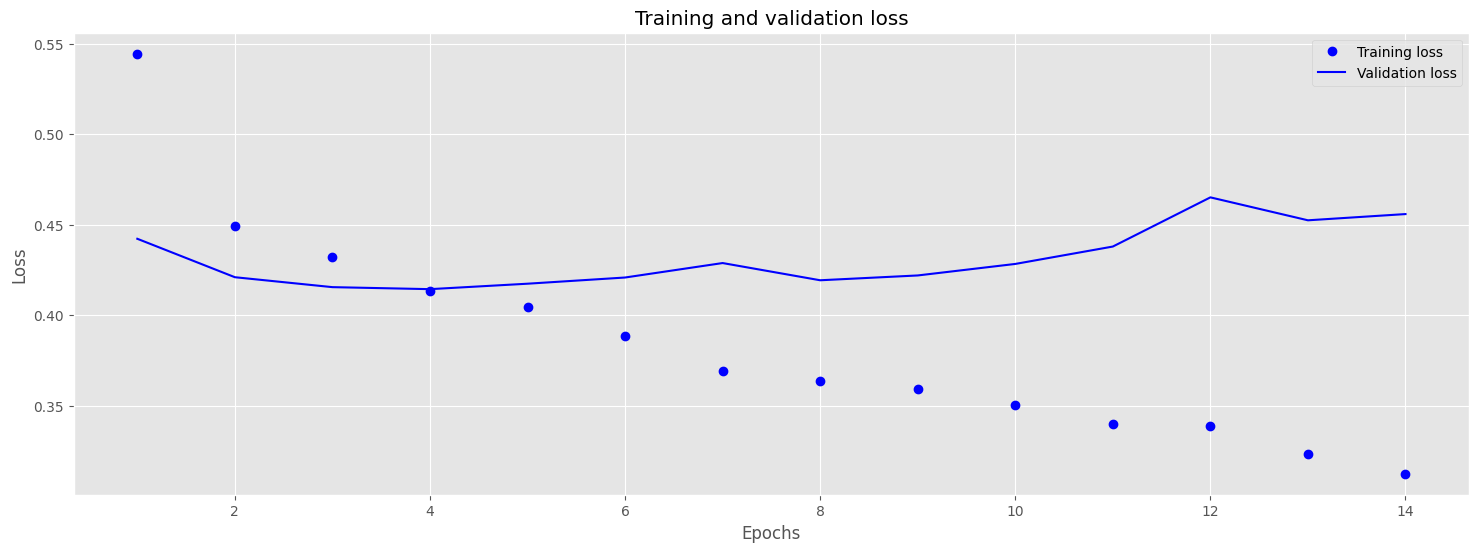

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

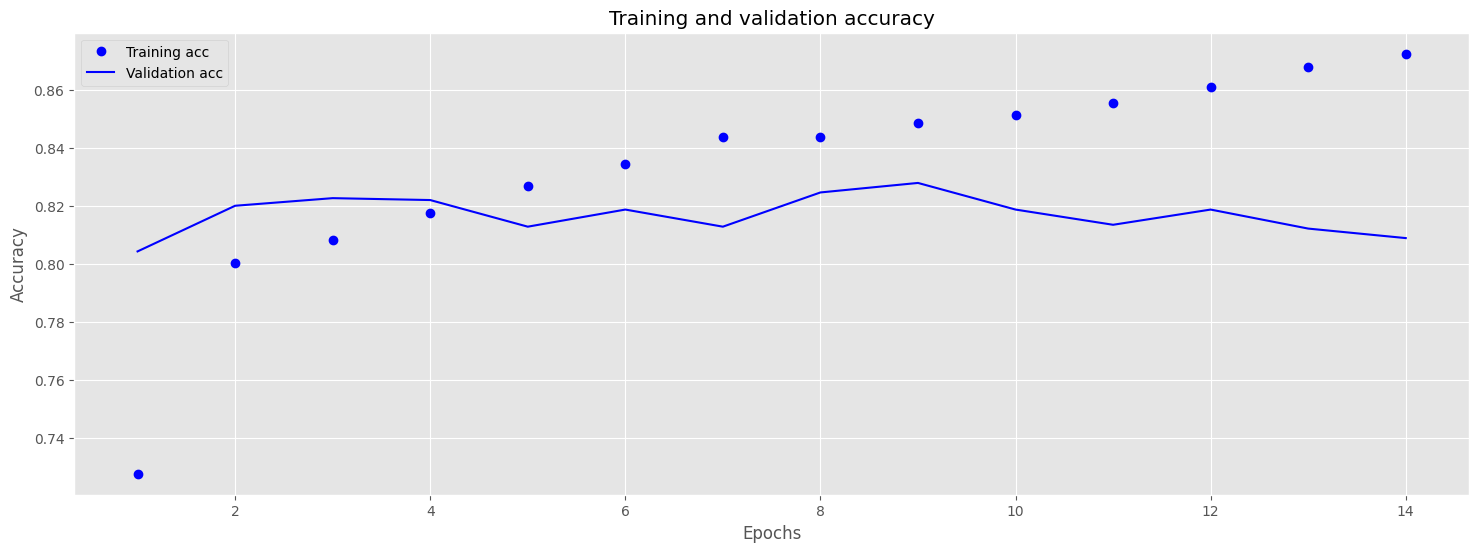

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')
predicted = loaded_model.predict(train[df_train.shape[0]:])
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
#리더보드 결과 : 0.809

102/102 [==============================] - 3s 4ms/step


# BERT

In [ ]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#train_data, val_data, train_labels, val_labels = train_test_split(df_train.text.values, df_train.target.values, test_size=0.2, random_state=10)
train_data, val_data, train_labels, val_labels = train_test_split(df['text'][:df_train.shape[0]].values, df_train['target'].values, test_size=0.2, stratify=df_train['target'].values, random_state=10)

In [ ]:
max_length = 34

In [ ]:
train_data = tokenizer(
    text = train_data.tolist(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

In [ ]:
train_data

{'input_ids': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[  101,  2610,  3102, ...,     0,     0,     0],
       [  101,  1049,  2232, ...,     0,     0,     0],
       [  101, 11352,  5856, ...,     0,     0,     0],
       ...,
       [  101, 12632,  3521, ...,     0,     0,     0],
       [  101,  2017,  4148, ...,     0,     0,     0],
       [  101,  2018,  3167, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
val_data = tokenizer(
    text = val_data.tolist(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [ ]:
max_len = 34


input_ids = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_mask')

embeddings = bert([input_ids, input_mask])[1]

out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.5)(out)
y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 34)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             109482240   ['input_ids[0][0]',              
                                                                  'input_mask[0][0]']             
                                                                                                  
 dense_2433 (Dense)             (None, 128)          98432       ['tf_bert_model[4][1]']    

In [ ]:
train_data['input_ids']

<tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[  101,  2610,  3102, ...,     0,     0,     0],
       [  101,  1049,  2232, ...,     0,     0,     0],
       [  101, 11352,  5856, ...,     0,     0,     0],
       ...,
       [  101, 12632,  3521, ...,     0,     0,     0],
       [  101,  2017,  4148, ...,     0,     0,     0],
       [  101,  2018,  3167, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

loss = BinaryCrossentropy(from_logits = True)

metric = BinaryAccuracy('accuracy')


model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=3                               
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    )
]

In [ ]:
history = model.fit(
    x ={'input_ids':train_data['input_ids'],'input_mask':train_data['attention_mask']} ,
    y = train_labels,
    validation_data = ({'input_ids':val_data['input_ids'],'input_mask':val_data['attention_mask']},val_labels),
    callbacks=callbacks_list,
    epochs=20,
    batch_size=64
)

Epoch 1/20
96/96 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8279
Epoch 1: val_accuracy improved from -inf to 0.83191, saving model to checkpoint_path.keras
96/96 [==============================] - 101s 623ms/step - loss: 0.4318 - accuracy: 0.8279 - val_loss: 0.4202 - val_accuracy: 0.8319
Epoch 2/20
96/96 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8691
Epoch 2: val_accuracy improved from 0.83191 to 0.83651, saving model to checkpoint_path.keras
96/96 [==============================] - 58s 610ms/step - loss: 0.3566 - accuracy: 0.8691 - val_loss: 0.4256 - val_accuracy: 0.8365
Epoch 3/20
96/96 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8773
Epoch 3: val_accuracy did not improve from 0.83651
96/96 [==============================] - 48s 497ms/step - loss: 0.3412 - accuracy: 0.8773 - val_loss: 0.4263 - val_accuracy: 0.8365
Epoch 4/20
96/96 [==============================] - ETA: 0s - loss: 0.3231 - accuracy

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras', custom_objects={"TFBertModel": TFBertModel})

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

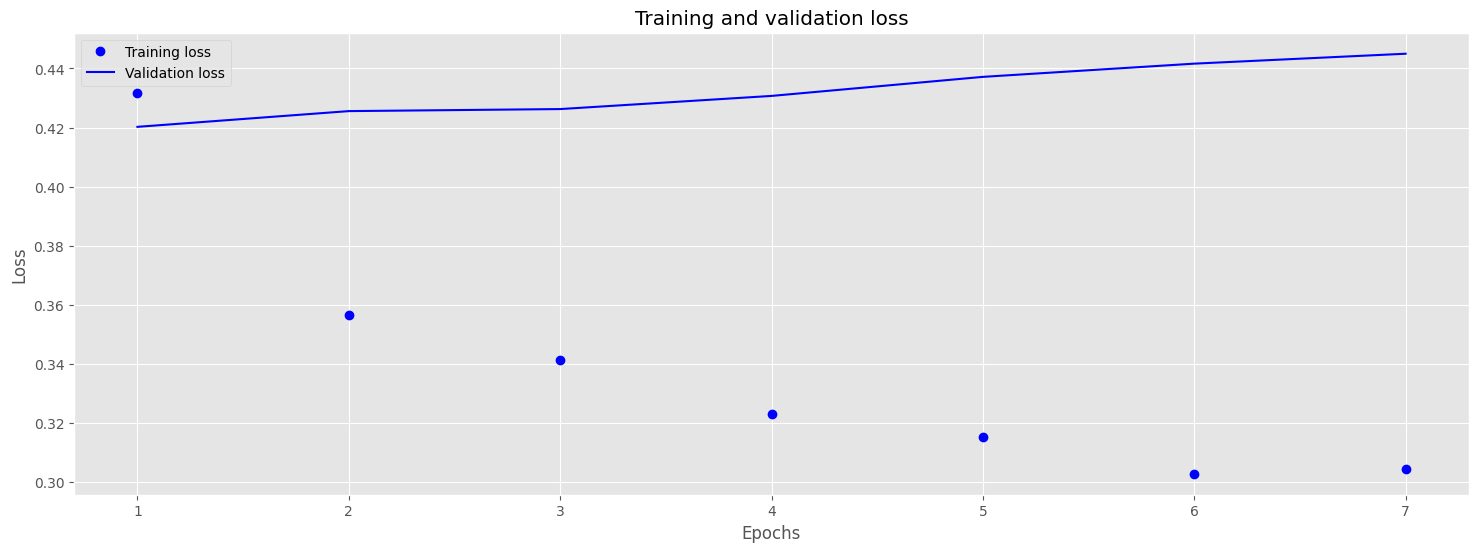

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

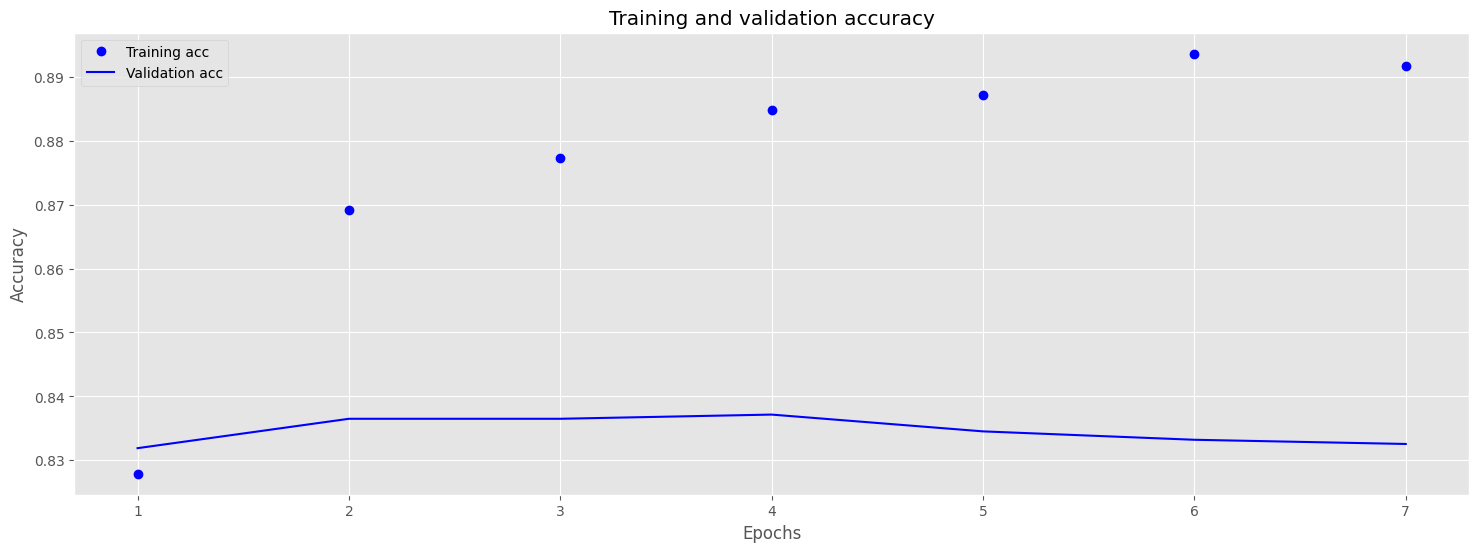

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
x_test = tokenizer(
    text=df_test.text.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test['attention_mask']

<tf.Tensor: shape=(3263, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
predicted = loaded_model.predict({'input_ids':x_test['input_ids'],'input_mask':x_test['attention_mask']})

102/102 [==============================] - 14s 107ms/step


In [ ]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
# 리더보드 0.82929